# Exploratory Data Analysis

In [ ]:
# import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal
import warnings
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data from csv
data_dir = '/content/drive/MyDrive/DAT 490 - Forest Flux/data/Crime_Data_from_2020_to_Present.csv'
df = pd.read_csv(data_dir)
df.head(3)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,0377,31,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0416 0334 2004 1822 1414 0305 0319 0400,32,M,H,102.0,SIDEWALK,200.0,KNIFE WITH BLADE 6INCHES OR LESS,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,0377,30,M,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509


## Data Prep

### Make all columns lowercase

In [ ]:
# Make all columns lowercase
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1-2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'location', 'cross_street', 'lat',
       'lon'],
      dtype='object')

### Convert all strings in the data to lowercase

In [ ]:
# convert all strings in the data lowercase
string_column_names = df.select_dtypes(include="object").columns # list of string columns
df[string_column_names] = df[string_column_names].astype(str).applymap(str.lower)
df.head(1)

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon
0,211507896,04/11/2021 12:00:00 am,11/07/2020 12:00:00 am,845,15,n hollywood,1502,2,354,theft of identity,0377,31,m,h,501.0,single family dwelling,NaN,nan,ic,invest cont,354.0,NaN,NaN,NaN,7800 beeman av,nan,34.2124,-118.4092


### Extract date attributes from date_rptd and date_Occ

In [ ]:
# Extract date attributes from date_rptd and date_Occ columns. (Adding 6 new columns)
date_cols = ["date_rptd", "date_occ"]
new_date_cols = []

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")
    new_date_cols.append(col)
    df[f"{col}_year"] = df[col].dt.year
    new_date_cols.append(f"{col}_year")
    df[f"{col}_month"] = df[col].dt.month
    new_date_cols.append(f"{col}_month")
    df[f"{col}_day"] = df[col].dt.day
    new_date_cols.append(f"{col}_day")

print("Added 6 new columns")
df[new_date_cols].head(1)

Added 6 new columns


,date_rptd,date_rptd_year,date_rptd_month,date_rptd_day,date_occ,date_occ_year,date_occ_month,date_occ_day
0,2021-04-11,2021,4,11,2020-11-07,2020,11,7


### Drop Nulls in select columns and drop duplicates

In [ ]:
# replace all string nan with pandas null type
df.replace(["nan", ""], np.nan, inplace=True)

In [ ]:
# List columns with missing values and there counts
missing_df = df.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df[missing_df["Missing_Count"] > 0]

,Column,Missing_Count
10,mocodes,151619
12,vict_sex,144644
13,vict_descent,144656
14,premis_cd,16
15,premis_desc,588
16,weapon_used_cd,677744
17,weapon_desc,677744
18,status,1
20,crm_cd_1,11
21,crm_cd_2,935831


In [ ]:
# remove missing values from selected columns
cols = ["premis_cd", "crm_cd_1"]
print("Original dataframe size:", df.shape)
df.dropna(subset=cols, inplace=True)
print("New dataframe size:", df.shape)

Original dataframe size: (1004991, 34)
New dataframe size: (1004964, 34)


In [ ]:
# Drop duplicates, keeping the first occurrence
print("Original dataframe size:", df.shape)
df.drop_duplicates(keep='first', inplace=True)
print("New dataframe size:", df.shape)

Original dataframe size: (1004964, 34)
New dataframe size: (1004964, 34)


In [ ]:
# Remonve h and - from the vict_sex column
print("Original dataframe size:", df.shape)
df = df[~df['vict_sex'].isin(['h', '-'])]
print("New dataframe size:", df.shape)

Original dataframe size: (1004964, 34)
New dataframe size: (1004849, 34)


In [ ]:
# Remonve - from the vict_descent column
print("Original dataframe size:", df.shape)
df = df[~df['vict_descent'].isin(['h', '-'])]
print("New dataframe size:", df.shape)

Original dataframe size: (1004849, 34)
New dataframe size: (708477, 34)


In [ ]:
# Remove invalid ages
print("Original dataframe size:", df.shape)
df = df[(df['vict_age'] > 0) & (df['vict_age'] <= 100)]
print("New dataframe size:", df.shape)

Original dataframe size: (708477, 34)
New dataframe size: (444006, 34)


In [ ]:

# Remove invalid vict_sex
print("Original dataframe size:", df.shape)
df = df[df['vict_sex'].notna()]
print("New dataframe size:", df.shape)

Original dataframe size: (444006, 34)
New dataframe size: (443976, 34)


In [ ]:
# Remove invalid premis_desc
print("Original dataframe size:", df.shape)
df = df[df['premis_desc'].notna()]
print("New dataframe size:", df.shape)

Original dataframe size: (443976, 34)
New dataframe size: (443803, 34)


#### Grammar collections and type mapping

In [ ]:
df['cross_street_refactored'] = df['cross_street'] \
    .str.lower() \
    .str.strip() \
    .str.replace(
        r'^(n|s|e|w)\s+broadway(\s+(st|av|ave|bl|blvd|pl|ct))?$',
        'broadway',
        regex=True
    ) \
    .str.replace(
        r'^broadway(\s+(st|av|ave|bl|blvd|pl|ct))?$',
        'broadway',
        regex=True
    ) \
    .str.replace(
        r'^(n|s|e|w)\s+figueroa(\s+(st|av|ave|bl|blvd|pl|tr|wy|dr))?$',
        'figueroa',
        regex=True
    ) \
    .str.replace(
        r'^figueroa(\s+(st|av|ave|bl|blvd|pl|tr|wy|dr))?$',
        'figueroa',
        regex=True
    ) \
    .str.replace(
        r'^(n|s|e|w)\s+western(\s+(av|ave|st|bl|blvd|pl))?$',
        'western av',
        regex=True
    ) \
    .str.replace(
        r'^western(\s+(av|ave|st|bl|blvd|pl))?$',
        'western av',
        regex=True
    ) \
    .str.replace(
        r'^(n|s|e|w)\s+vermont(\s+(av|ave|st|bl|blvd|pl))?$',
        'vermont av',
        regex=True
    ) \
    .str.replace(
        r'^vermont(\s+(av|ave|st|bl|blvd|pl))?$',
        'vermont av',
        regex=True
    ) \
    .str.replace(
        r'^(n|s|e|w)\s+san pedro(\s+(st|av|ave|bl|blvd|pl))?$',
        'san pedro st',
        regex=True
    ) \
    .str.replace(
        r'^san pedro(\s+(st|av|ave|bl|blvd|pl))?$',
        'san pedro st',
        regex=True
    )
df['cross_street_refactored'].value_counts().head(5)

,count
cross_street_refactored,
figueroa,1589
western av,1225
vermont av,1121
broadway,1010
san pedro st,983


In [ ]:
# Group victim Ethnicity
df['vict_descent_grouped'] = df['vict_descent'] \
    .map({
        'w': 'White',
        'b': 'Black',
        'a': 'Asian',
        'x': 'Unknown'
    }).fillna('Other')
df['vict_descent_grouped'].value_counts()

,count
vict_descent_grouped,
White,186479
Black,134194
Other,85044
Asian,20999
Unknown,17087


In [ ]:
# Convert to datetime, then extract time only (Create columns: time_occ_time, and time_occ_time_hour)
time_occ = pd.to_datetime(
    df['time_occ'].astype(str).str.zfill(4), # Zero-pad to 4 digits (e.g., 45 → 0045)
    format='%H%M',
    errors='coerce'
)
df['time_occ_time'] = time_occ.dt.time
df['time_occ_time_hour'] = time_occ.dt.hour
df['time_occ_time_hour'].head(3)

,time_occ_time_hour
2,12
3,13
5,12


In [ ]:
# create crime types
df['crime_type'] = df['part_1-2'].astype(int).replace({1: 'Violent', 2: 'Non-Violent'})
df['crime_type'].head(3)

,crime_type
2,Non-Violent
3,Violent
5,Non-Violent


In [ ]:
age_bins = [0, 18, 30, 45, 60, 75, 100]
age_labels = ['0–17', '18–29', '30–44', '45–59', '60–74', '75+']
df['age_group'] = pd.cut(
    df['vict_age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)
df['age_group'].head(3)

,age_group
2,30–44
3,45–59
5,30–44


In [ ]:
# group reporting days
bins = [0, 3, float('inf')]
labels = ['0', '1'] # 0–2 days: low reporting, 3+ days
# Calculate the difference in days
df['days_to_report'] = (df['date_rptd'] - df['date_occ']).dt.days
df['rpt_duration'] = pd.cut(
    df['days_to_report'],
    bins=bins,
    labels=labels,
    right=False
).astype(int)
print("Original dataframe size:", df.shape)
df = df[df['rpt_duration'].notna()]
print("New dataframe size:", df.shape)


Original dataframe size: (443803, 42)
New dataframe size: (443803, 42)


## Univariate Analysis

#### Temporal Information

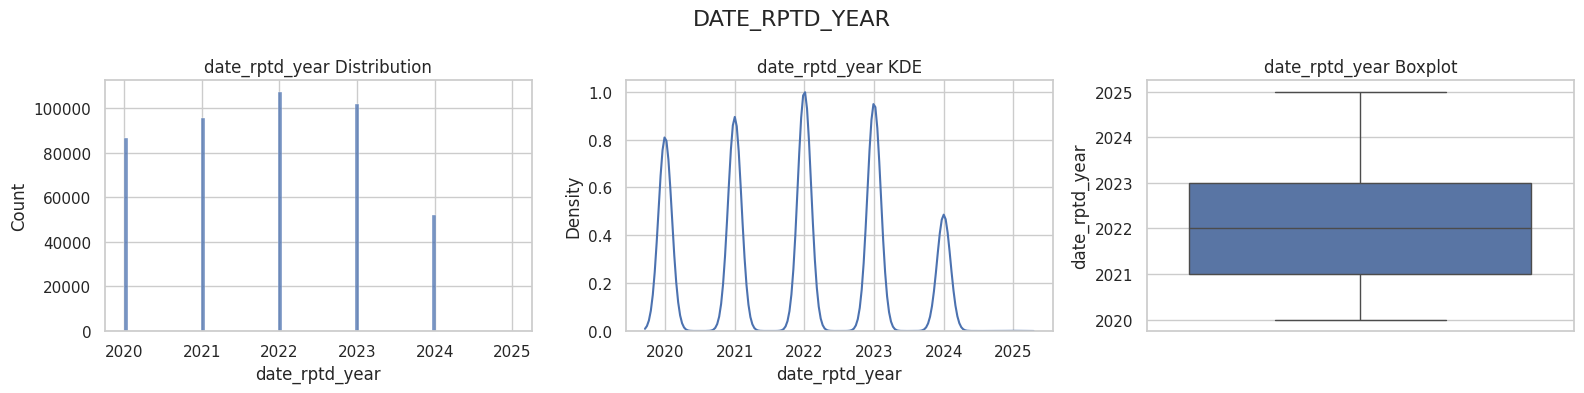

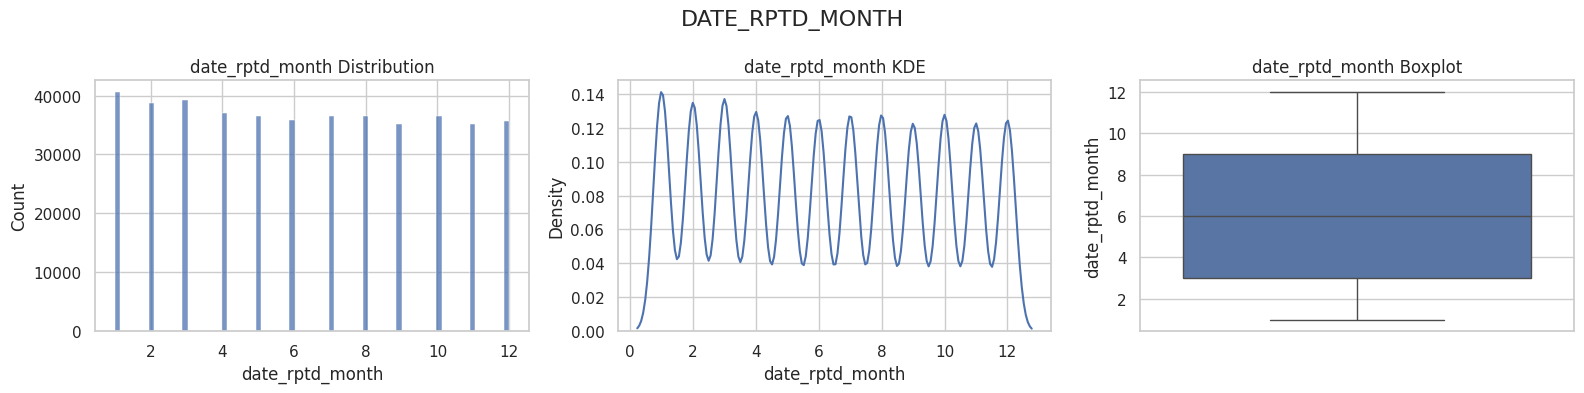

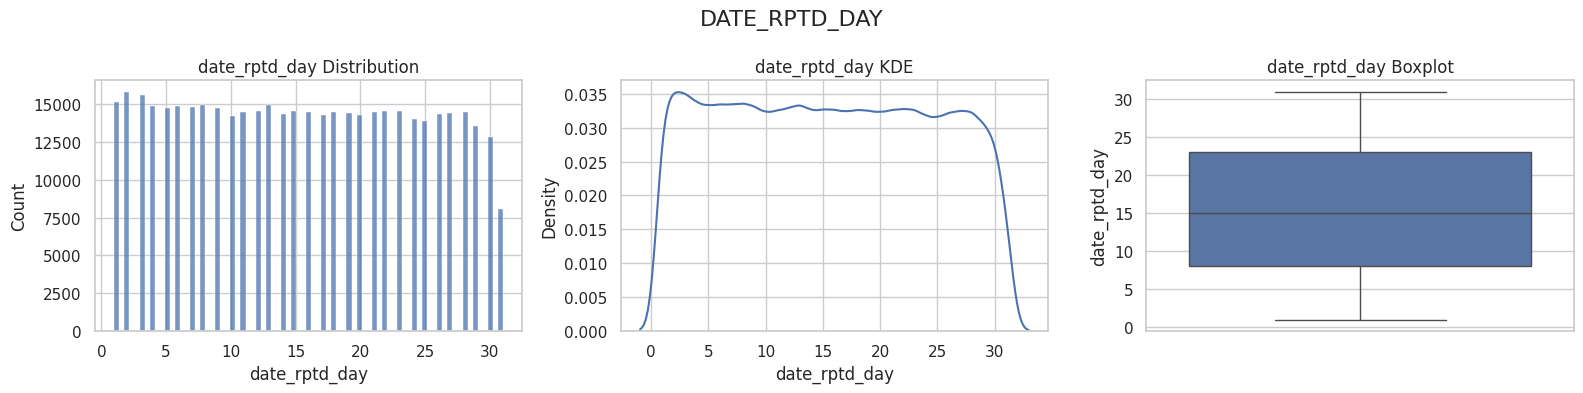

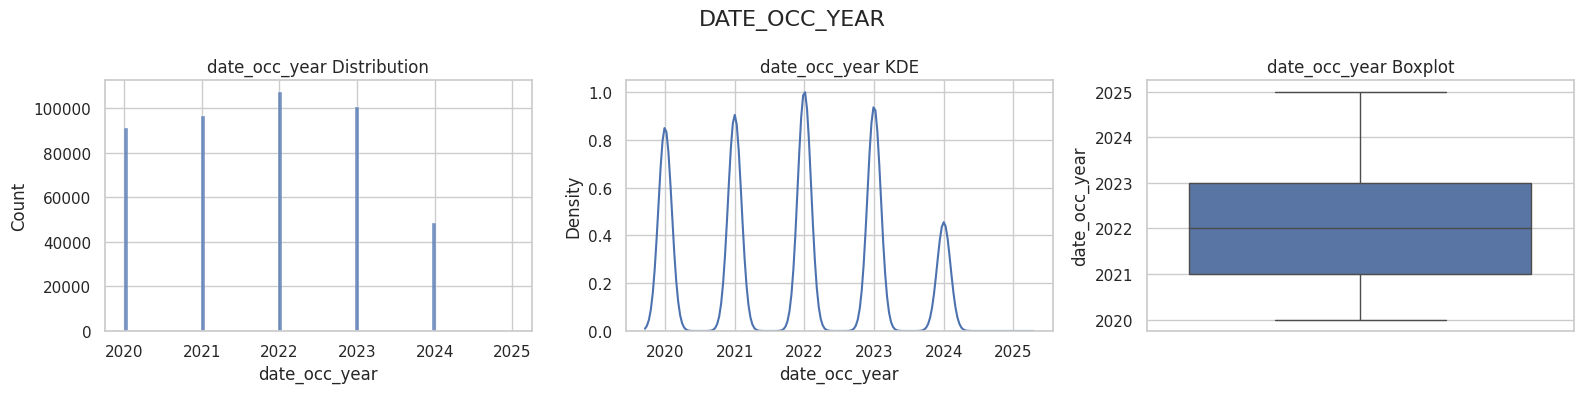

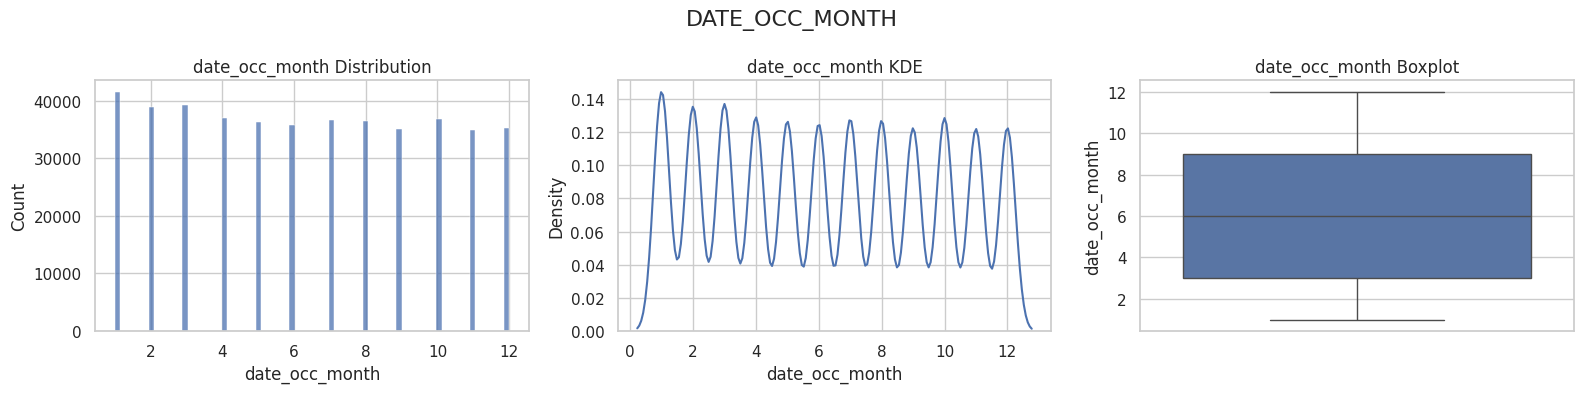

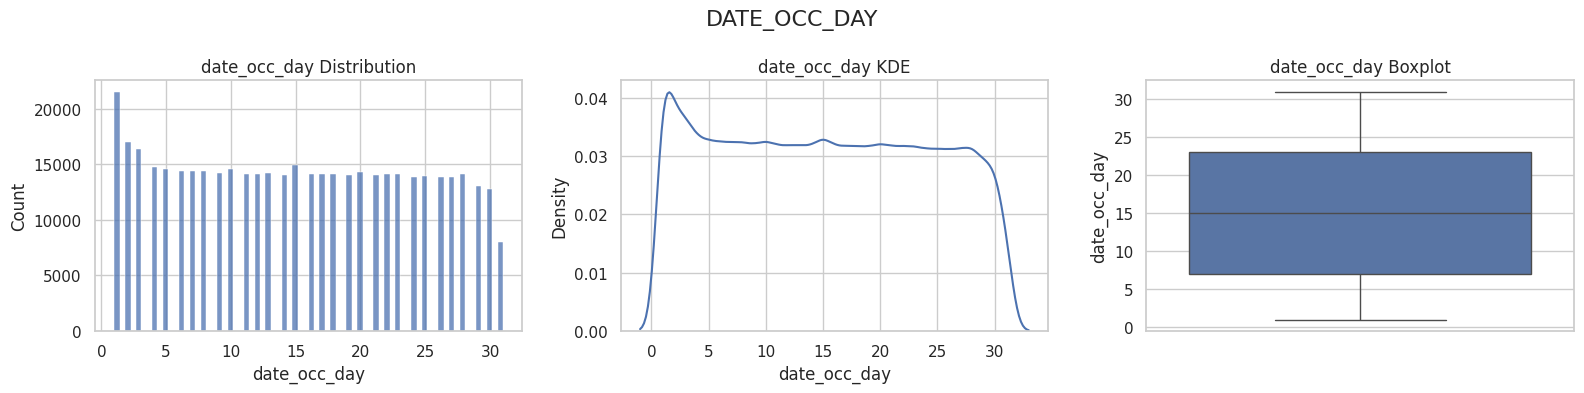

In [ ]:
# get all numeric column names
numeric_cols = ['date_rptd_year','date_rptd_month',
        'date_rptd_day', 'date_occ_year', 'date_occ_month', 'date_occ_day']
# get column value count visuals
for col in numeric_cols:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
    sns.histplot(df[col], ax=ax[0])
    sns.kdeplot(df[col], ax=ax[1])
    sns.boxplot(y=df[col], ax=ax[2])

    ax[0].set_title(f"{col} Distribution")
    ax[1].set_title(f"{col} KDE")
    ax[2].set_title(f"{col} Boxplot")

    fig.suptitle(f"{col.upper()}", fontsize=16)
    plt.tight_layout()
    plt.show()

**Notes**:
- **`date_rptd_year` and `date_occ_year`**:  
  Crime counts peak in **2023**, while **2024** has the lowest number of reported and occurred crimes.

- **`date_rptd_month` and `date_occ_month`**:  
  Reported and occurred crime counts remain relatively consistent across all months.

- **`date_rptd_day` and `date_occ_day`**:  
  The **31st day of the month** has the lowest combined reported and occurred crime count, while all other days show similar levels.

#### Geographic Information

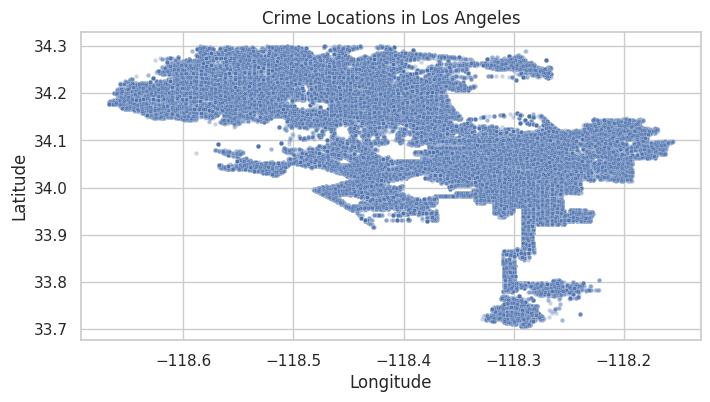

In [ ]:
# Filter for valid LA coordinates
df_geo = df[(df['lat'] > 33.7) & (df['lat'] < 34.3) &
            (df['lon'] > -118.7) & (df['lon'] < -118.1)]

# Scatter plot of crime locations
plt.figure(figsize=(8, 4))
sns.scatterplot(x='lon', y='lat', data=df_geo, alpha=0.3, s=10)
plt.title('Crime Locations in Los Angeles')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

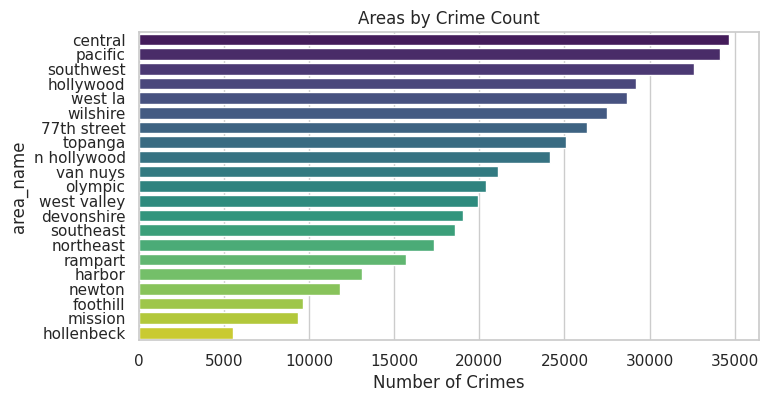

In [ ]:
# Bar chart for Area
plt.figure(figsize=(8, 4))
area_name = df['area_name'].value_counts()
sns.barplot(x=area_name.values, y=area_name.index, palette='viridis')
plt.title('Areas by Crime Count')
plt.xlabel('Number of Crimes')
plt.show()

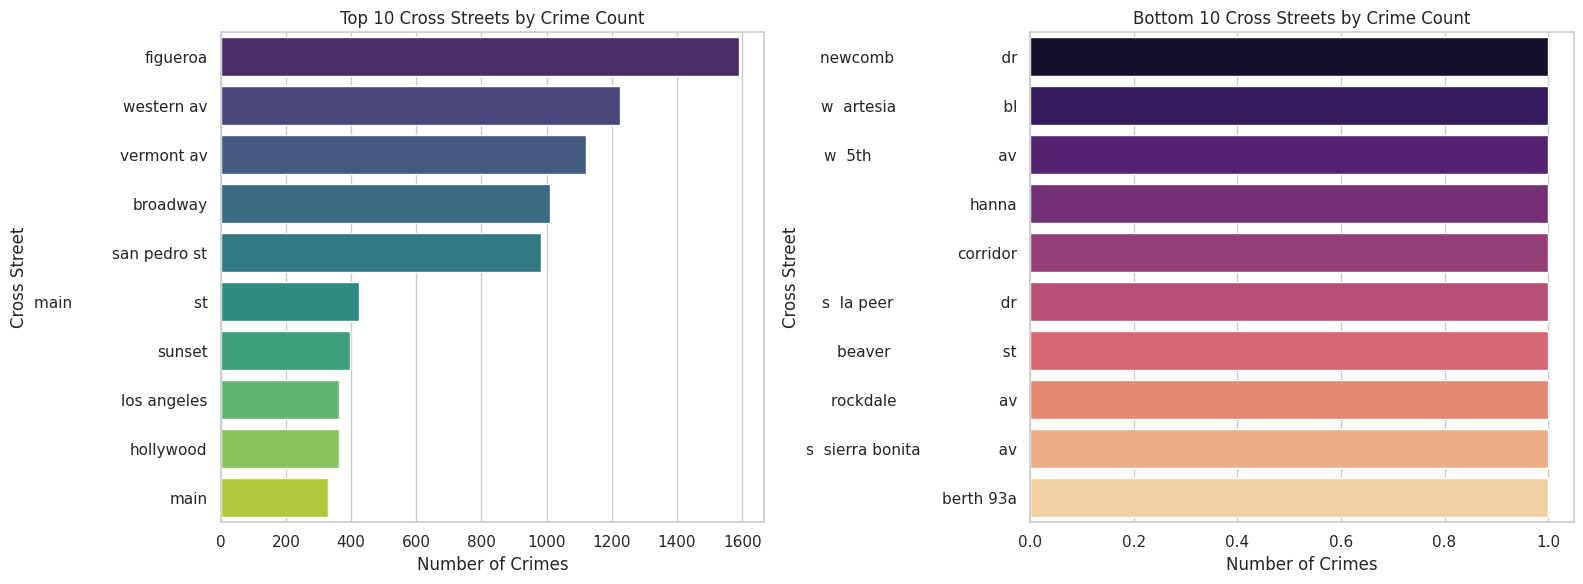

In [ ]:
# Bar chart for top and bottom cross streets
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Top 10
top_streets = df['cross_street_refactored'].value_counts(dropna=True).head(10)
sns.barplot(x=top_streets.values, y=top_streets.index, palette='viridis', ax=ax[0])
ax[0].set_title('Top 10 Cross Streets by Crime Count')
ax[0].set_xlabel('Number of Crimes')
ax[0].set_ylabel('Cross Street')

# Bottom 10
bottom_streets = df['cross_street_refactored'].value_counts(dropna=True).tail(10)
sns.barplot(x=bottom_streets.values, y=bottom_streets.index, palette='magma', ax=ax[1])
ax[1].set_title('Bottom 10 Cross Streets by Crime Count')
ax[1].set_xlabel('Number of Crimes')
ax[1].set_ylabel('Cross Street')

plt.tight_layout()
plt.show()

In [ ]:
# df['cross_street'][df['cross_street'].str.contains('san pedro', case=False, na=False)].value_counts()

**Notes**:
- **`lat` and `lon`**: The visualization highlights the geographic locations of all reported crimes.

- **`area` and `area_name`**: The visualization shows all areas in Los Angeles affected by crime. The areas with the highest crime counts are `central`, `pacific`, and `hollywood`, while `mission`, `hollenbeck`, and `foothill` have the lowest counts. Crime totals in each of the top two areas (`central` or `pacific`) are nearly equivalent to the combined totals of the three lowest areas.

- **`cross_street_refactored`**: The top five streets/avenues with the highest crime counts are `figueroa`, `vermont av`, `western av`, `broadway`, and `san pedro st`. `figueroa` accounts for nearly 1,600 crimes, while each of the others has approximately 1,000 or more incidents.


| Created Group | Variants Included |
|----------------|------------------|
| broadway | `broadway`, `broadway st`, `broadway av`, `broadway bl`, `broadway pl`, `broadway ct`, `n/s/e/w broadway (+ st/av/bl/pl/ct)` |
| figueroa | `figueroa`, `figueroa st`, `figueroa av`, `figueroa bl`, `figueroa pl`, `figueroa tr`, `figueroa wy`, `figueroa dr`, `n/s/e/w figueroa (+ st/av/bl/pl)` |
| western av | `western`, `western av`, `western st`, `western bl`, `western pl`, `n/s/e/w western (+ av/st/bl/pl)` |
| vermont av | `vermont`, `vermont av`, `vermont st`, `vermont bl`, `vermont pl`, `n/s/e/w vermont (+ av/st/bl/pl)` |
| san pedro st | `san pedro`, `san pedro st`, `san pedro av`, `san pedro bl`, `san pedro pl`, `n/s/e/w san pedro (+ st/av/bl/pl)` |

### Victim Demographics

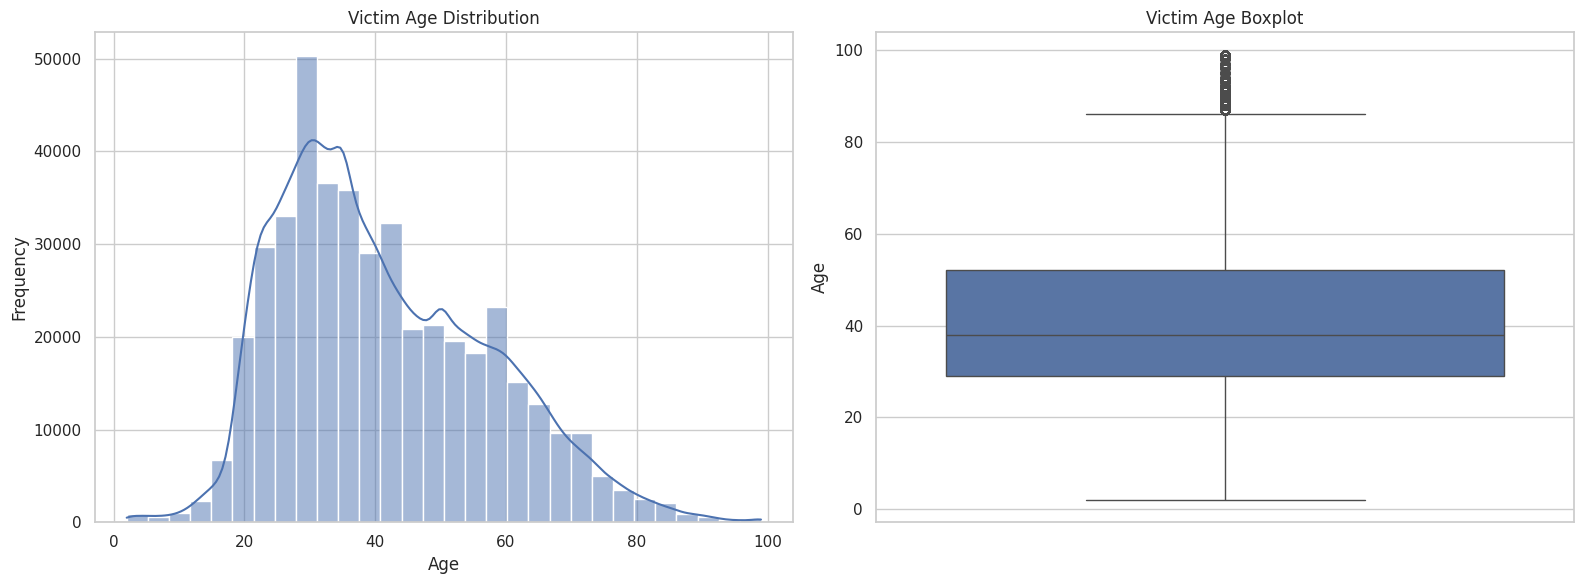

In [ ]:
# Histogram and Boxplot for Victim Age
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Histogram
sns.histplot(df['vict_age'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Victim Age Distribution')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(y=df['vict_age'], ax=ax[1])
ax[1].set_title('Victim Age Boxplot')
ax[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

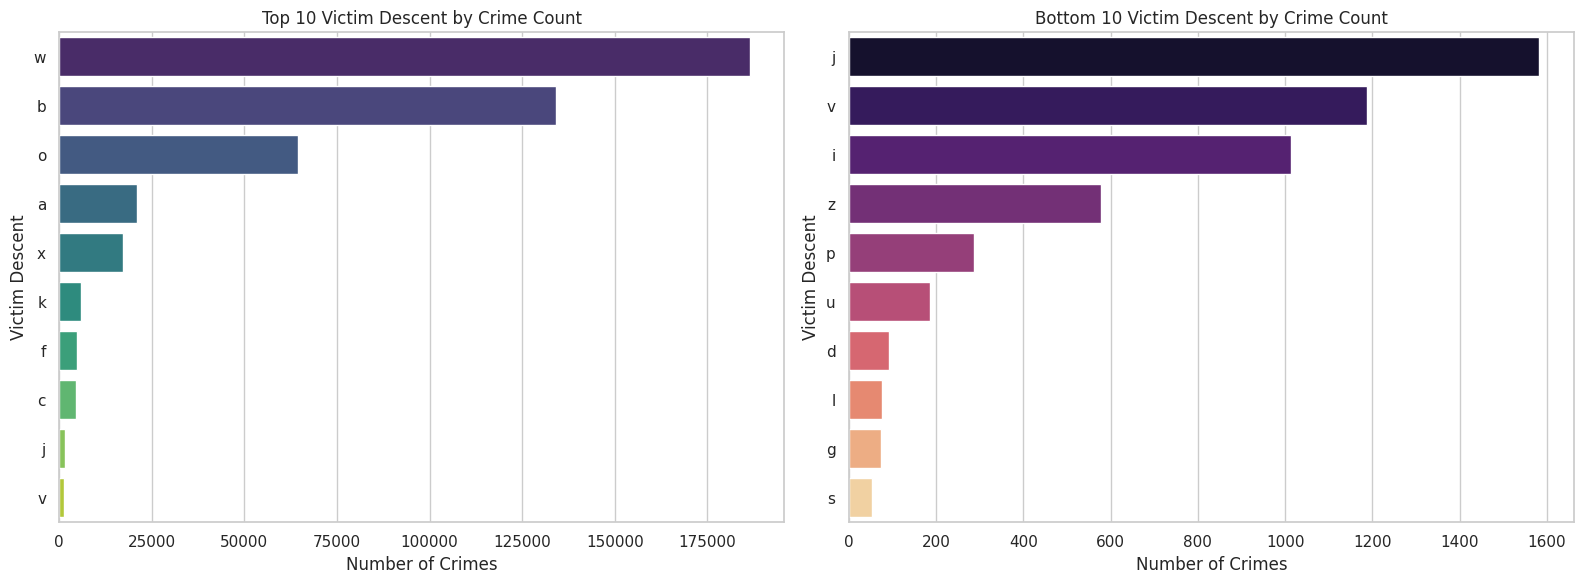

In [ ]:
# Bar chart for top and bottom victim descent
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Top 10
vict_descent = df['vict_descent'].value_counts().head(10)
sns.barplot(x=vict_descent.values, y=vict_descent.index, palette='viridis', ax=ax[0])
ax[0].set_title('Top 10 Victim Descent by Crime Count')
ax[0].set_xlabel('Number of Crimes')
ax[0].set_ylabel('Victim Descent')

# Bottom 10
vict_descent = df['vict_descent'].value_counts().tail(10)
sns.barplot(x=vict_descent.values, y=vict_descent.index, palette='magma', ax=ax[1])
ax[1].set_title('Bottom 10 Victim Descent by Crime Count')
ax[1].set_xlabel('Number of Crimes')
ax[1].set_ylabel('Victim Descent')

plt.tight_layout()
plt.show()

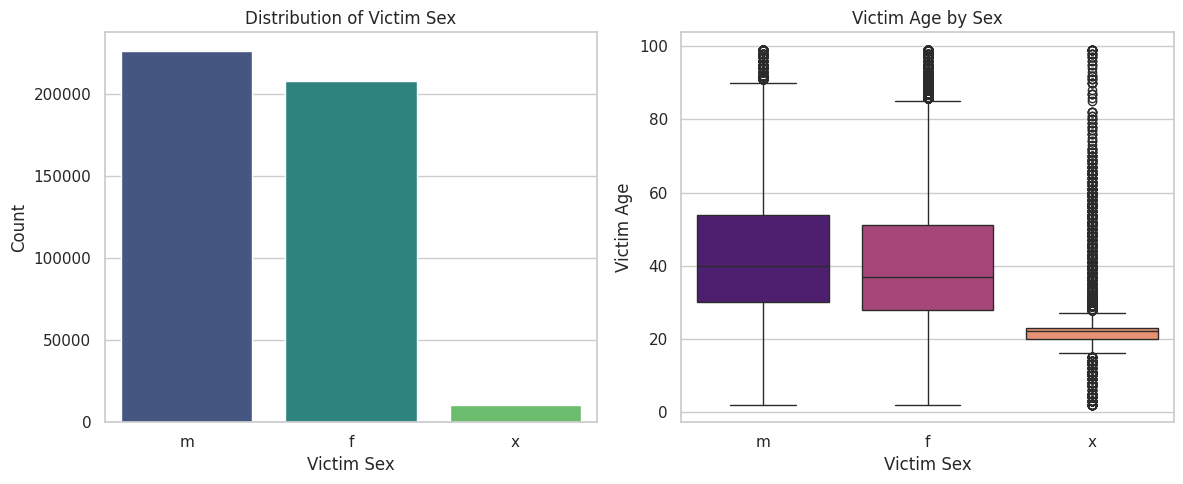

In [ ]:
# Histogram and Boxplot for Victim Sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram (count plot for categorical data)
sns.countplot(x='vict_sex', data=df, palette='viridis', ax=ax[0])
ax[0].set_title('Distribution of Victim Sex')
ax[0].set_xlabel('Victim Sex')
ax[0].set_ylabel('Count')

# Boxplot (showing distribution across categories)
sns.boxplot(x='vict_sex', y='vict_age', data=df, palette='magma', ax=ax[1])
ax[1].set_title('Victim Age by Sex')
ax[1].set_xlabel('Victim Sex')
ax[1].set_ylabel('Victim Age')

plt.tight_layout()
plt.show()

**Notes**:

- `vict_age`: A total of **264,341 records** with a victim age of `0` were removed. The value `0` is treated as **unknown age**, as its meaning in the data collection process is unclear. These records were excluded both to avoid ambiguity and to meet the project requirement of working with approximately **100,000 records**. The value `0` is reserved for potential future expansion of the project.  
  - The visualization shows a **unimodal distribution** with a single clear peak between **ages 30 and 40**, where the mean is concentrated. Victims over **80 years of age** are present but are considered **outliers**.

- `vict_sex`: The data indicates that the majority of victims are **male**.

- `vict_descent`: This column represents the victim’s ethnic origin. The visualization indicates that **`White`** and **`Black`** victims account for the highest counts. All remaining ethnic groups are combined into **`Other`**, except for **`Other Asian`**, which is reclassified as **`Asian`**. Records labeled as **`Unknown`** are excluded from the analysis.

  | Code | Description |
  |------|-------------|
  | W | White |
  | B | Black |
  | O | Other |
  | A | Other Asian |
  | X | Unknown |
  | S | Samoan |
  | J | Japanese |
  | I | American Indian / Alaskan Native |
  | D | Cambodian |

#### Crime Characteristics

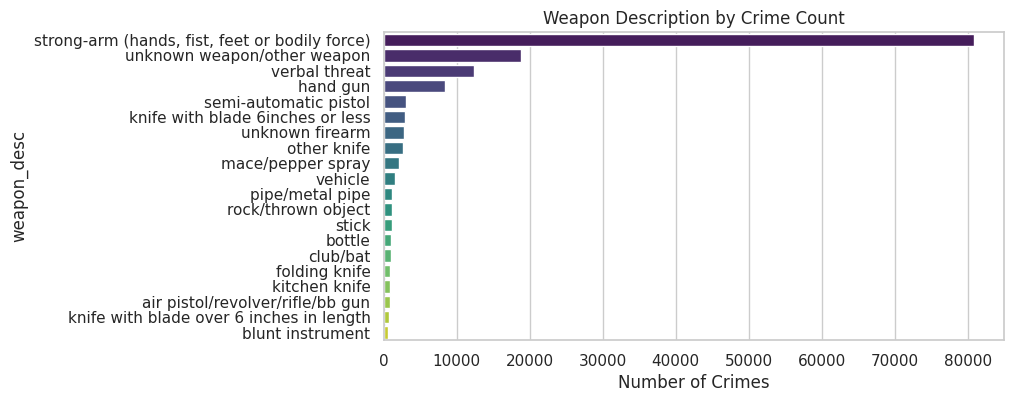

In [ ]:
# Bar chart for Area
plt.figure(figsize=(8, 4))
weapon_desc = df['weapon_desc'].value_counts().head(20)
sns.barplot(x=weapon_desc.values, y=weapon_desc.index, palette='viridis')
plt.title('Weapon Description by Crime Count')
plt.xlabel('Number of Crimes')
plt.show()

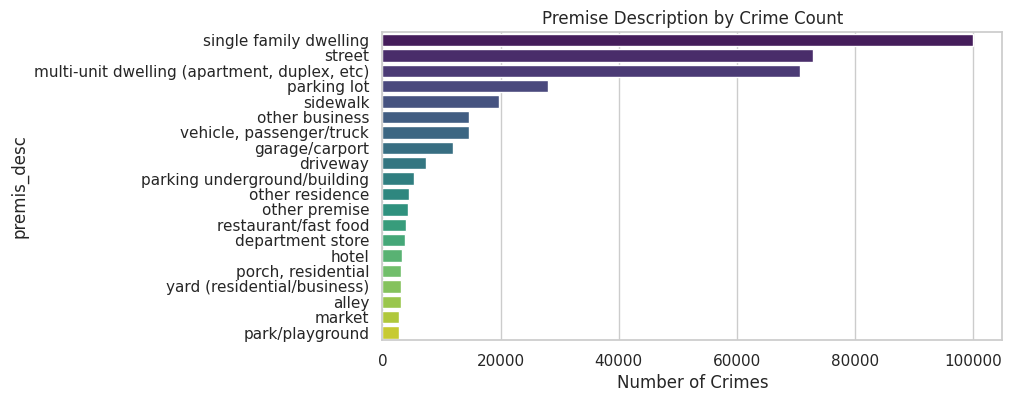

In [ ]:
# Bar chart for Area
plt.figure(figsize=(8, 4))
premis_desc = df['premis_desc'].value_counts().head(20)
sns.barplot(x=premis_desc.values, y=premis_desc.index, palette='viridis')
plt.title('Premise Description by Crime Count')
plt.xlabel('Number of Crimes')
plt.show()

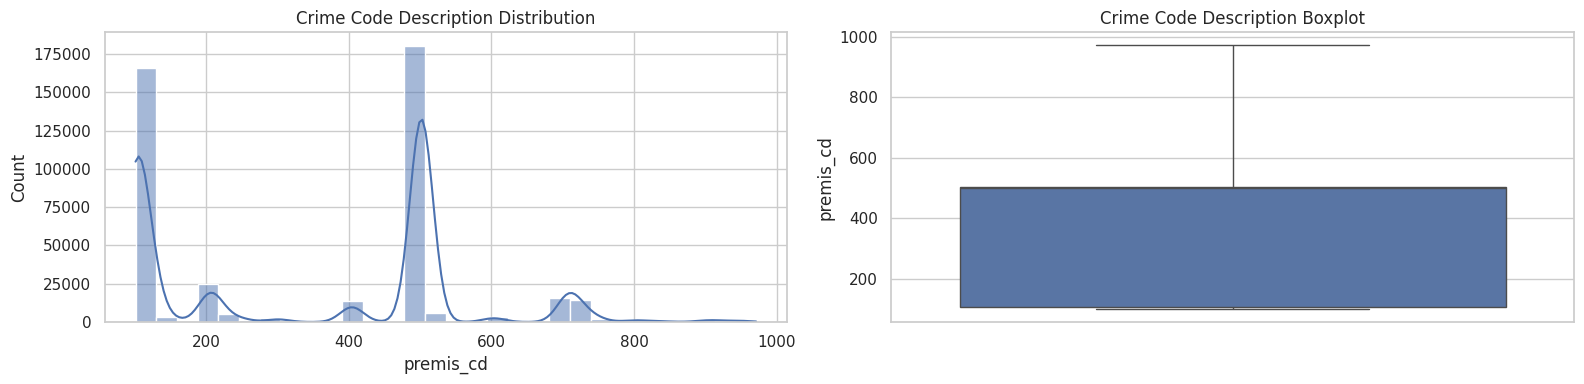

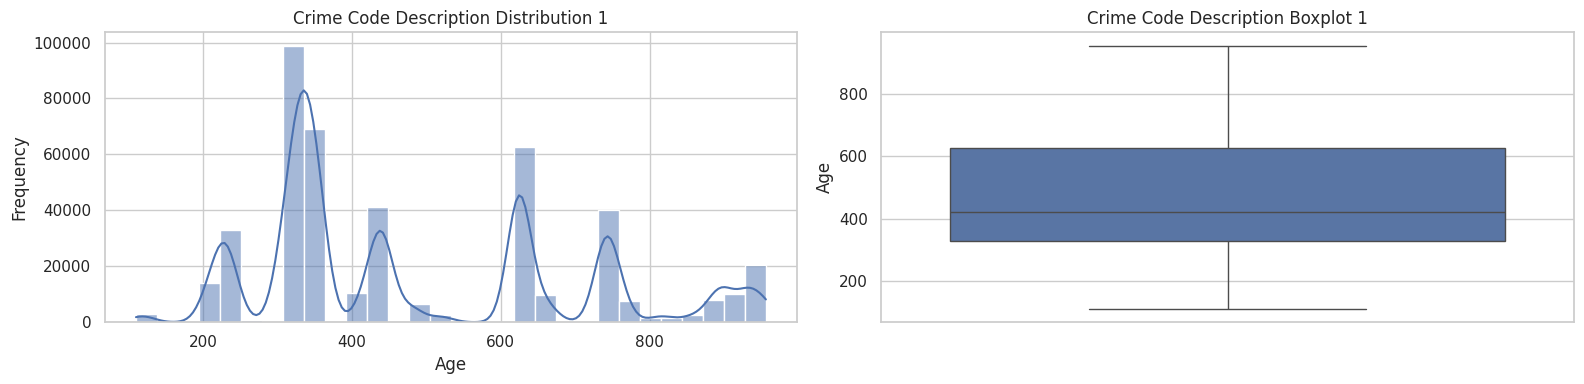

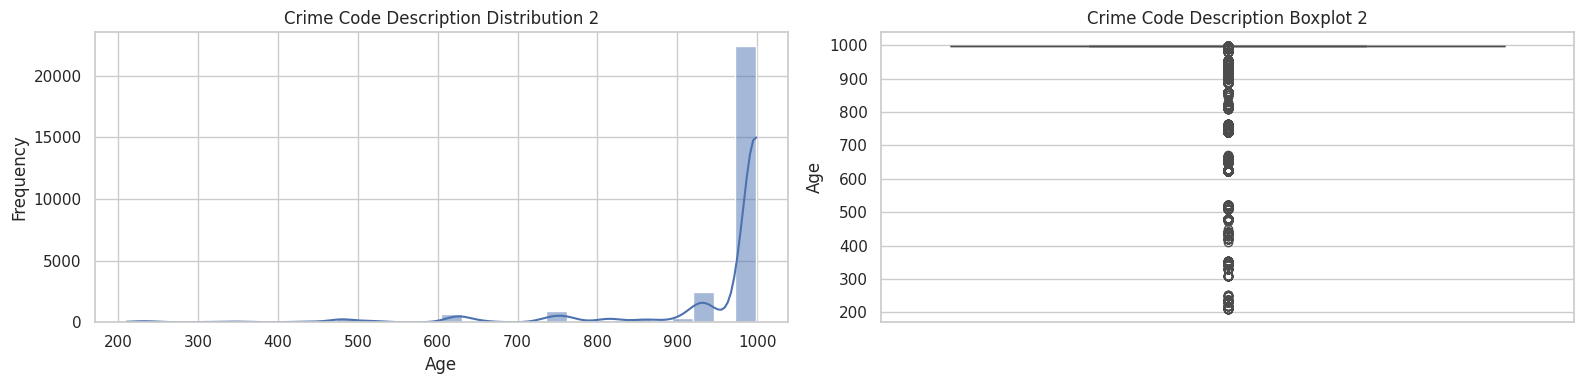

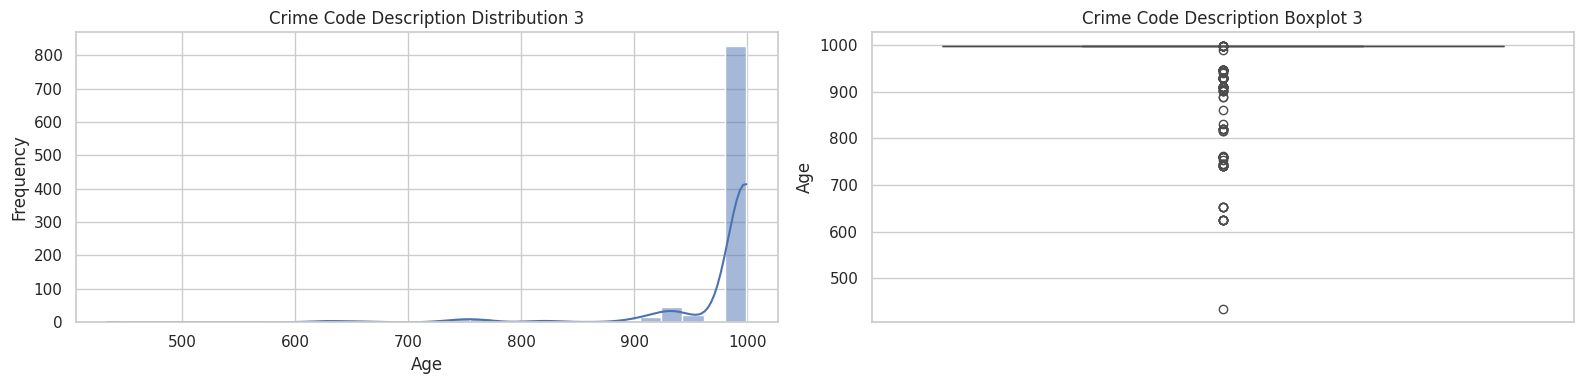

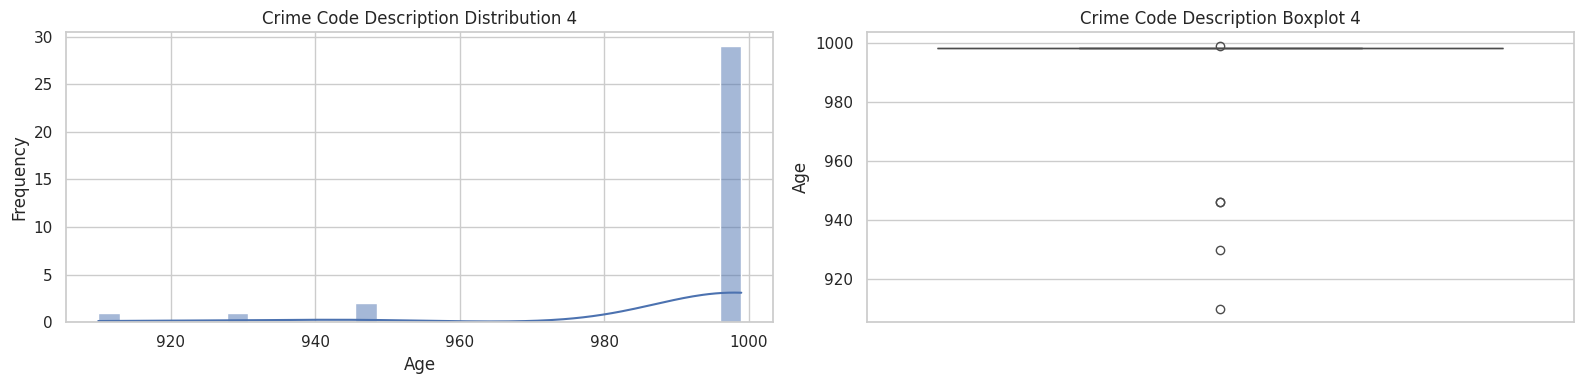

In [ ]:
crm_cd = ['premis_cd', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4']

for col in crm_cd:
  # Histogram and Boxplot for Victim Age
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

  # Histogram
  sns.histplot(df[col], bins=30, kde=True, ax=ax[0])
  if col == 'premis_cd':
    ax[0].set_title(f'Crime Code Description Distribution')
  else:
    ax[0].set_title(f'Crime Code Description Distribution {col[-1]}')
    ax[0].set_xlabel('Age')
    ax[0].set_ylabel('Frequency')

  # Boxplot
  sns.boxplot(y=df[col], ax=ax[1])
  if col == 'premis_cd':
    ax[1].set_title(f'Crime Code Description Boxplot')
  else:
    ax[1].set_title(f'Crime Code Description Boxplot {col[-1]}')
    ax[1].set_ylabel('Age')
  plt.tight_layout()
  plt.show()

## Bivariate Analysis

**Are crimes occurring at certain time_occ hours reported faster or slower?**

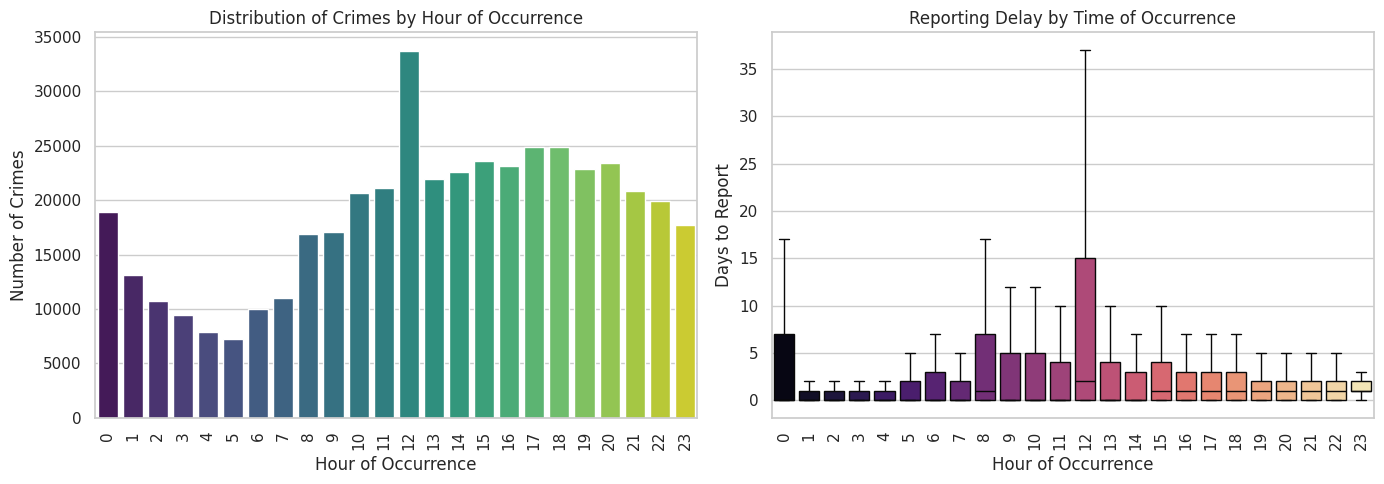

In [ ]:
# time_occ_hour × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(
    x='time_occ_time_hour',
    data=df,
    palette='viridis',
    ax=ax[0]
)
ax[0].set_title('Distribution of Crimes by Hour of Occurrence')
ax[0].set_xlabel('Hour of Occurrence')
ax[0].set_ylabel('Number of Crimes')
ax[0].tick_params(axis='x', rotation=90)

# Boxplot: Reporting delay by hour of occurrence
sns.boxplot(
    x='time_occ_time_hour',
    y='days_to_report',
    data=df,
    palette='magma',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay by Time of Occurrence')
ax[1].set_xlabel('Hour of Occurrence')
ax[1].set_ylabel('Days to Report')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


**Do crimes occurring on different days of the month show different reporting delays?**

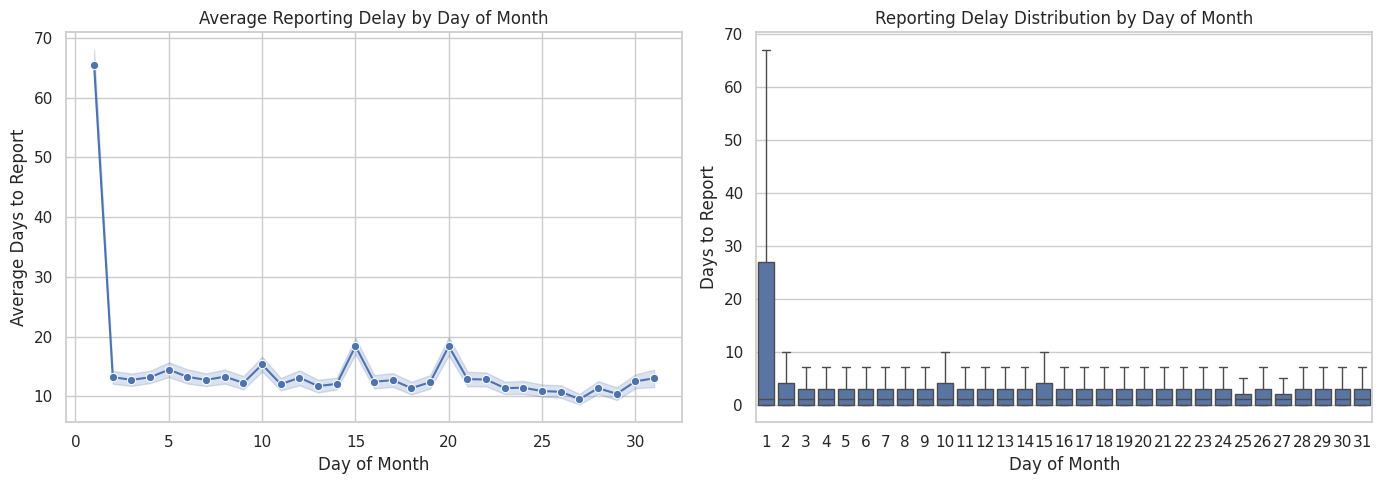

In [ ]:
# date_occ_day × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.lineplot(
    data=df,
    x='date_occ_day',
    y='days_to_report',
    marker='o',
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Day of Month')
ax[0].set_xlabel('Day of Month')
ax[0].set_ylabel('Average Days to Report')

# Boxplot: distribution of delays by day of month
sns.boxplot(
    x='date_occ_day',
    y='days_to_report',
    data=df,
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Day of Month')
ax[1].set_xlabel('Day of Month')
ax[1].set_ylabel('Days to Report')

plt.tight_layout()
plt.show()

**How does reporting delay vary by month or year of occurrence?**

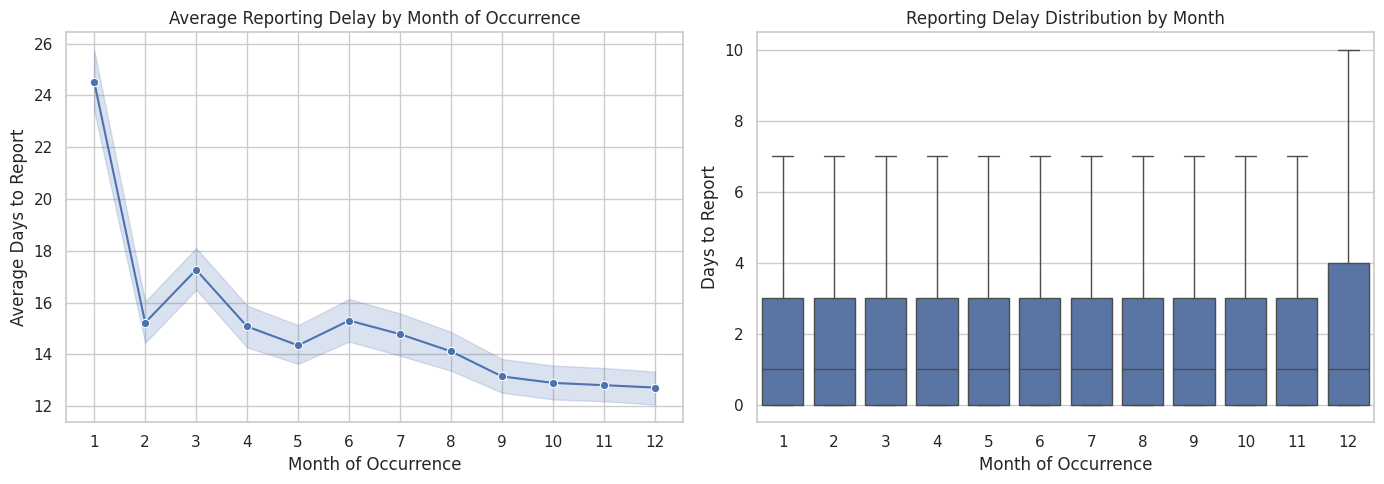

In [ ]:
# date_occ_month  × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.lineplot(
    data=df,
    x='date_occ_month',
    y='days_to_report',
    marker='o',
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Month of Occurrence')
ax[0].set_xlabel('Month of Occurrence')
ax[0].set_ylabel('Average Days to Report')
ax[0].set_xticks(range(1, 13))

# Boxplot: distribution of delays by month
sns.boxplot(
    x='date_occ_month',
    y='days_to_report',
    data=df,
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Month')
ax[1].set_xlabel('Month of Occurrence')
ax[1].set_ylabel('Days to Report')

plt.tight_layout()
plt.show()

**How does reporting delay differ by area_name?**

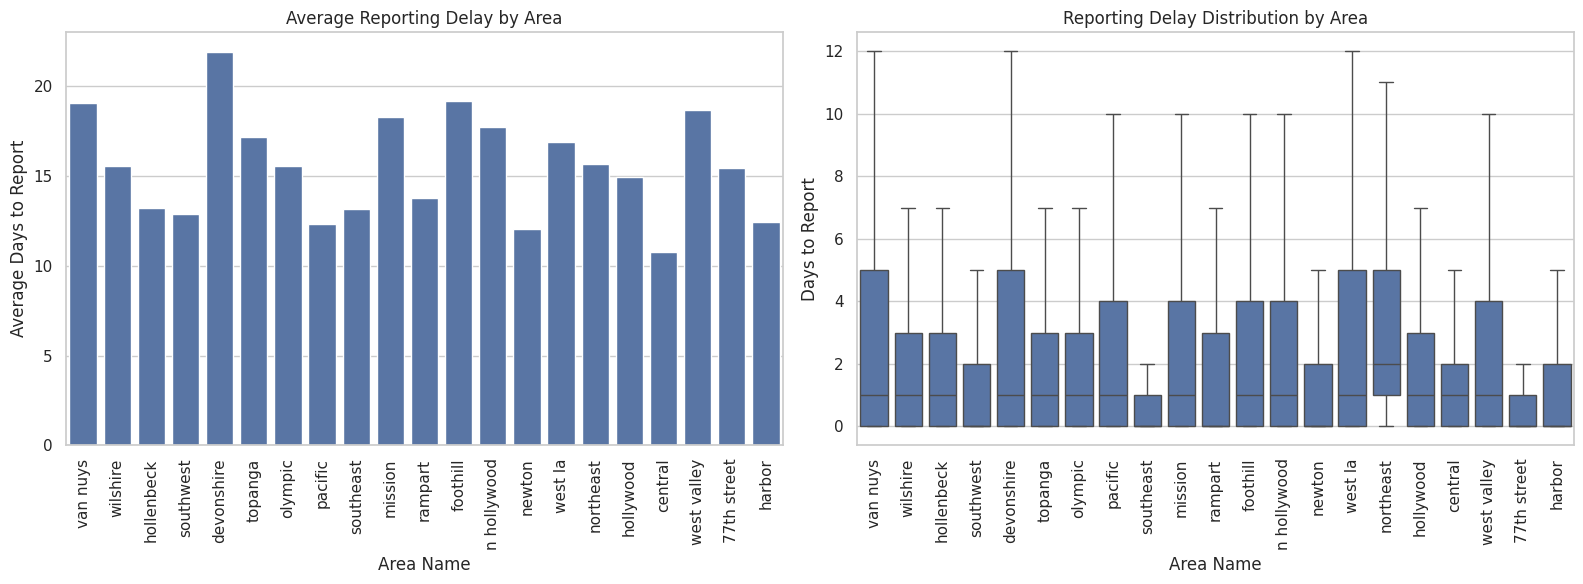

In [ ]:
# area_name x days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.barplot(
    x='area_name',
    y='days_to_report',
    data=df,
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Area')
ax[0].set_xlabel('Area Name')
ax[0].set_ylabel('Average Days to Report')
ax[0].tick_params(axis='x', rotation=90)

# Boxplot: distribution of reporting delay by area
sns.boxplot(
    x='area_name',
    y='days_to_report',
    data=df,
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Area')
ax[1].set_xlabel('Area Name')
ax[1].set_ylabel('Days to Report')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Are violent crimes reported faster than non-violent crimes?**

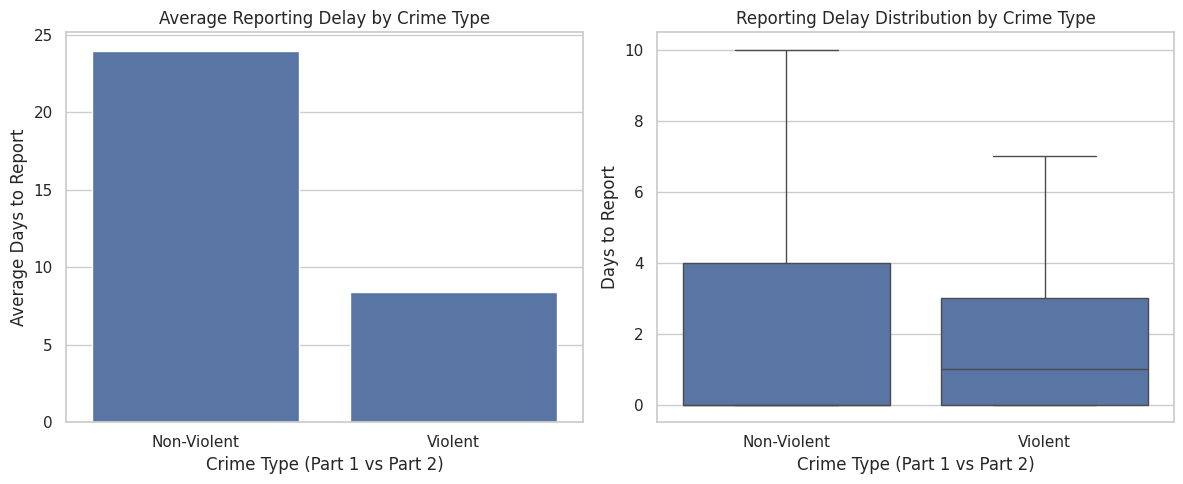

In [ ]:
# part_1-2 × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.barplot(
    x='crime_type',
    y='days_to_report',
    data=df,
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Crime Type')
ax[0].set_xlabel('Crime Type (Part 1 vs Part 2)')
ax[0].set_ylabel('Average Days to Report')

# Boxplot: distribution of reporting delay by crime type
sns.boxplot(
    x='crime_type',
    y='days_to_report',
    data=df,
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Crime Type')
ax[1].set_xlabel('Crime Type (Part 1 vs Part 2)')
ax[1].set_ylabel('Days to Report')

plt.tight_layout()
plt.show()

**How does reporting delay differ by specific crime type?**

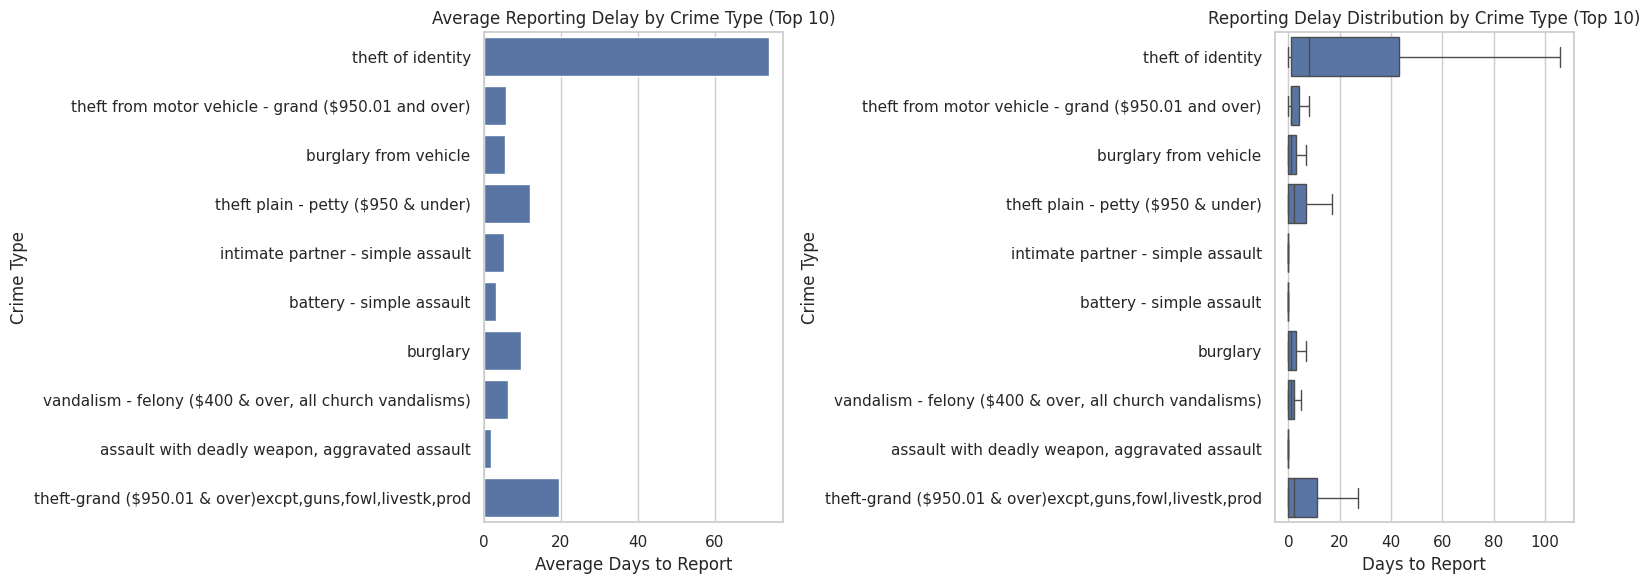

In [ ]:
# crm_cd_desc × days_to_report
top_10_crimes = (
    df['crm_cd_desc']
    .value_counts()
    .head(10)
    .index
)
df_top10 = df[df['crm_cd_desc'].isin(top_10_crimes)]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.barplot(
    data=df_top10,
    y='crm_cd_desc',
    x='days_to_report',
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Crime Type (Top 10)')
ax[0].set_xlabel('Average Days to Report')
ax[0].set_ylabel('Crime Type')
ax[0].tick_params(axis='y', rotation=0)
for label in ax[0].get_yticklabels():
    label.set_ha('right')

# Boxplot: distribution of reporting delay
sns.boxplot(
    data=df_top10,
    y='crm_cd_desc',
    x='days_to_report',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Crime Type (Top 10)')
ax[1].set_xlabel('Days to Report')
ax[1].set_ylabel('Crime Type')
ax[1].tick_params(axis='y', rotation=0)
for label in ax[1].get_yticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()

**Does weapon involvement affect reporting speed?**

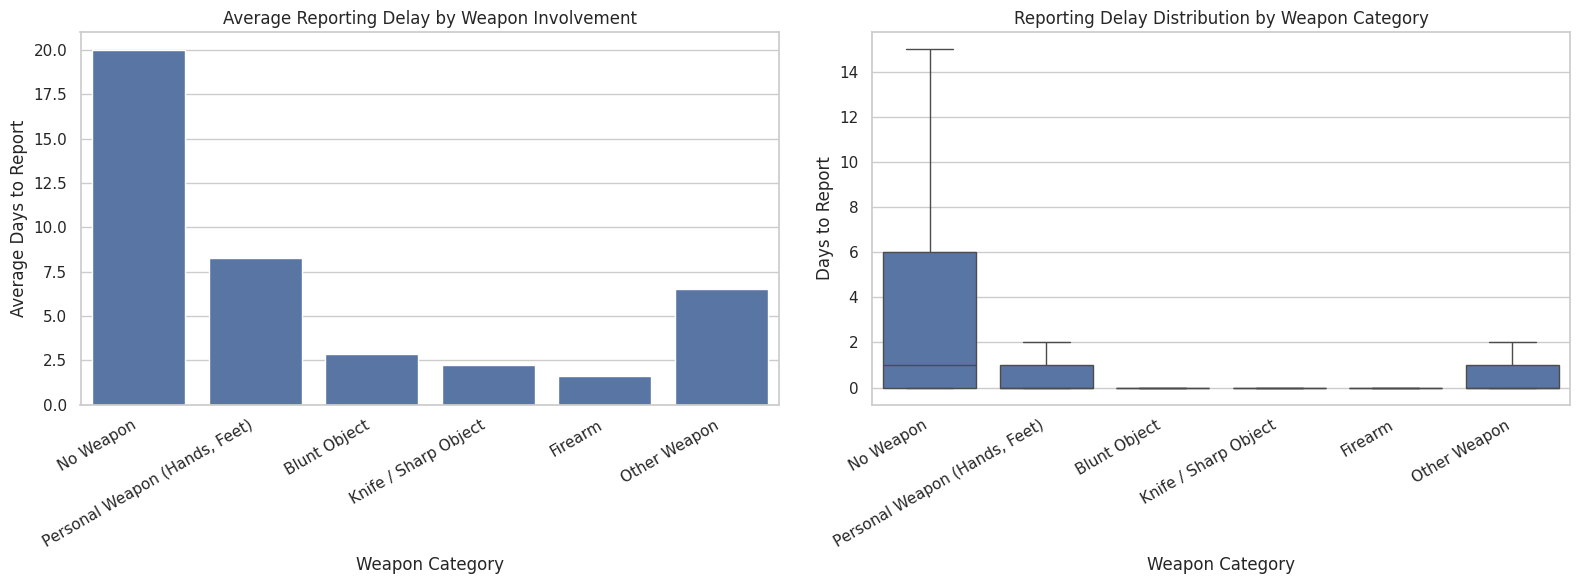

In [ ]:
# Weapon category grouping
def weapon_category(code):
    if pd.isna(code):
        return 'No Weapon'
    elif 100 <= code < 200:
        return 'Firearm'
    elif 200 <= code < 300:
        return 'Knife / Sharp Object'
    elif 300 <= code < 400:
        return 'Blunt Object'
    elif 400 <= code < 500:
        return 'Personal Weapon (Hands, Feet)'
    elif 500 <= code < 600:
        return 'Other Weapon'
    else:
        return 'Unknown'

df['weapon_category'] = df['weapon_used_cd'].apply(weapon_category)

category_order = [
    'No Weapon',
    'Personal Weapon (Hands, Feet)',
    'Blunt Object',
    'Knife / Sharp Object',
    'Firearm',
    'Other Weapon'
]

# weapon_category × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.barplot(
    x='weapon_category',
    y='days_to_report',
    data=df,
    order=category_order,
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Weapon Involvement')
ax[0].set_xlabel('Weapon Category')
ax[0].set_ylabel('Average Days to Report')
ax[0].tick_params(axis='x', rotation=30)
for label in ax[0].get_xticklabels():
    label.set_ha('right')

# Boxplot: distribution of delays
sns.boxplot(
    x='weapon_category',
    y='days_to_report',
    data=df,
    order=category_order,
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Weapon Category')
ax[1].set_xlabel('Weapon Category')
ax[1].set_ylabel('Days to Report')
ax[1].tick_params(axis='x', rotation=30)
for label in ax[1].get_xticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()


**How does reporting delay vary across victim age?**

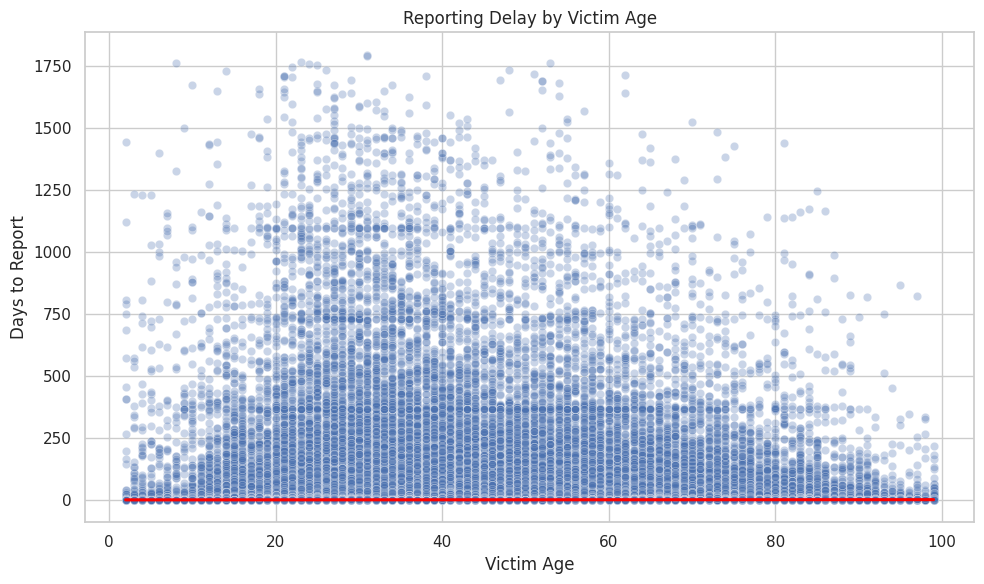

In [ ]:
# vict_age × days_to_report
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='vict_age',
    y='days_to_report',
    alpha=0.3
)

# Add smooth trend line
sns.regplot(
    data=df,
    x='vict_age',
    y='days_to_report',
    scatter=False,
    lowess=True,
    color='red'
)

plt.title('Reporting Delay by Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Days to Report')

plt.tight_layout()
plt.show()

**Do reporting delays differ by victim sex?**

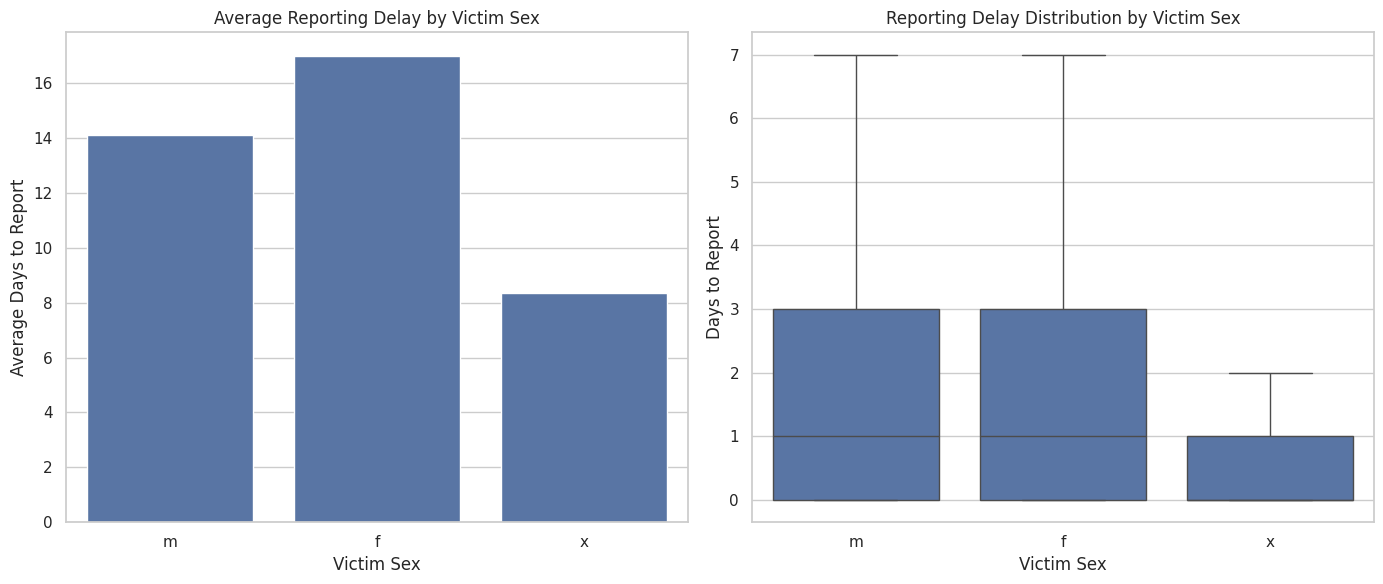

In [ ]:
# vict_sex × days_to_report
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Bar plot: average reporting delay
sns.barplot(
    data=df,
    x='vict_sex',
    y='days_to_report',
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Victim Sex')
ax[0].set_xlabel('Victim Sex')
ax[0].set_ylabel('Average Days to Report')

# Box plot: distribution of delays
sns.boxplot(
    data=df,
    x='vict_sex',
    y='days_to_report',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Victim Sex')
ax[1].set_xlabel('Victim Sex')
ax[1].set_ylabel('Days to Report')

plt.tight_layout()
plt.show()

**Are there differences in reporting delay across victim descent groups?**

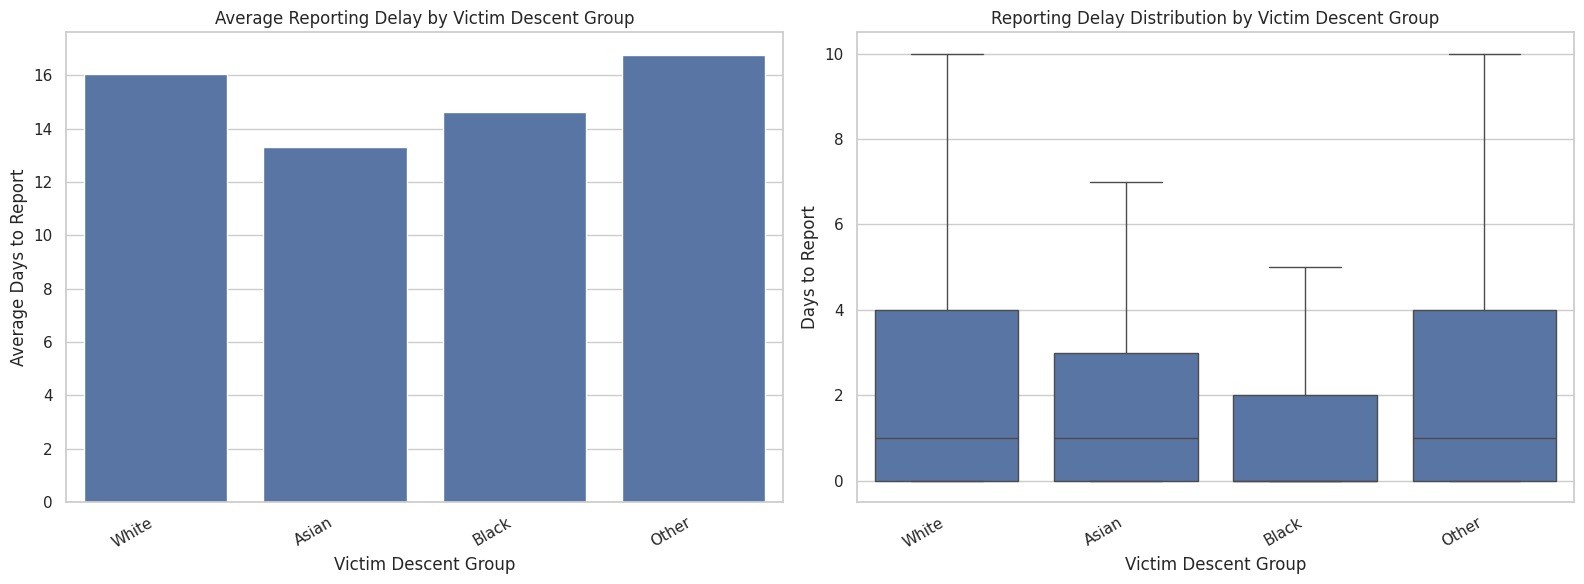

In [ ]:
# vict_descent_grouped × days_to_report
df_descent = df[df['vict_descent_grouped'] != 'Unknown']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bar plot: average reporting delay
sns.barplot(
    data=df_descent,
    x='vict_descent_grouped',
    y='days_to_report',
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Victim Descent Group')
ax[0].set_xlabel('Victim Descent Group')
ax[0].set_ylabel('Average Days to Report')
ax[0].tick_params(axis='x', rotation=30)
for label in ax[0].get_xticklabels():
    label.set_ha('right')

# Box plot: distribution of delays
sns.boxplot(
    data=df_descent,
    x='vict_descent_grouped',
    y='days_to_report',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Victim Descent Group')
ax[1].set_xlabel('Victim Descent Group')
ax[1].set_ylabel('Days to Report')
ax[1].tick_params(axis='x', rotation=30)
for label in ax[1].get_xticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()

**Does reporting delay vary by reporting district within areas?**

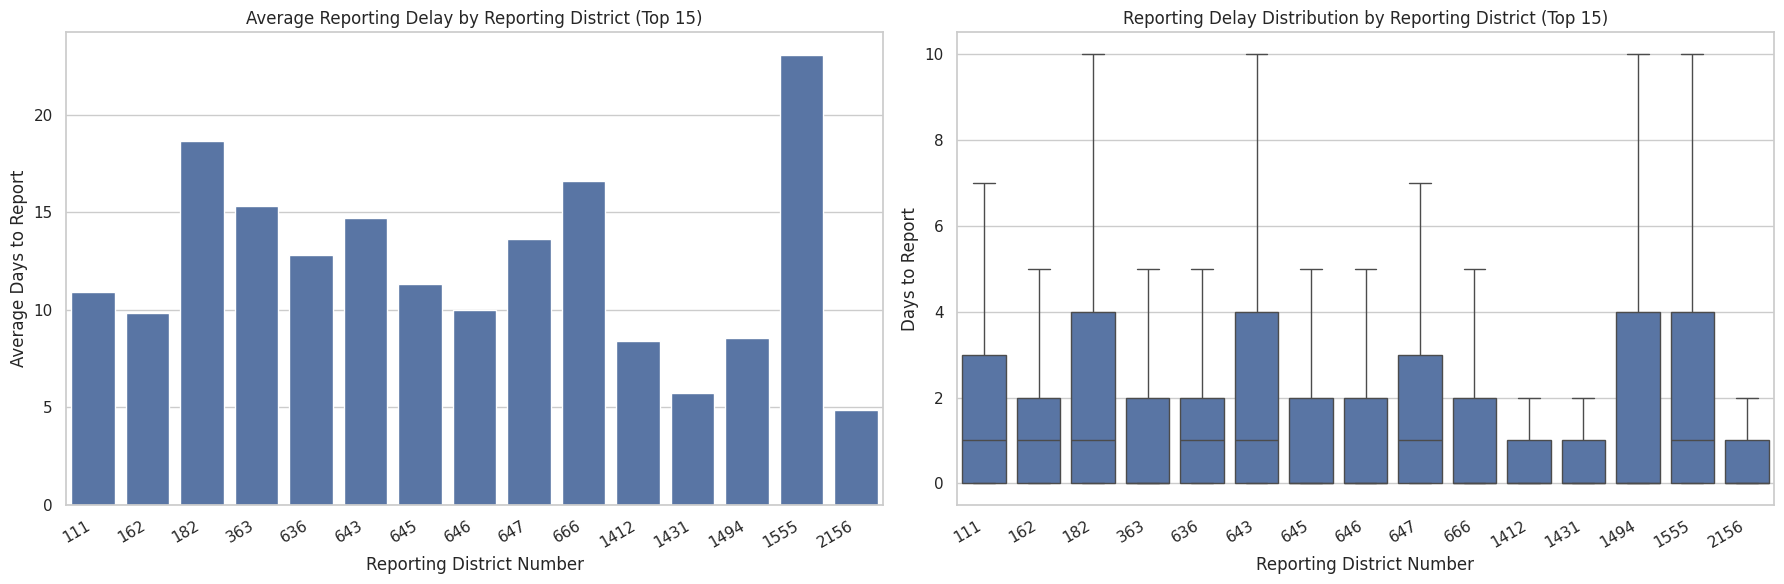

In [ ]:
# rpt_dist_no × days_to_report
top_districts = (
    df['rpt_dist_no']
    .value_counts()
    .head(15)
    .index
)

df_dist = df[df['rpt_dist_no'].isin(top_districts)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Bar plot: average reporting delay
sns.barplot(
    data=df_dist,
    x='rpt_dist_no',
    y='days_to_report',
    estimator='mean',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Average Reporting Delay by Reporting District (Top 15)')
ax[0].set_xlabel('Reporting District Number')
ax[0].set_ylabel('Average Days to Report')
ax[0].tick_params(axis='x', rotation=30)
for label in ax[0].get_xticklabels():
    label.set_ha('right')

# Box plot: distribution of delays
sns.boxplot(
    data=df_dist,
    x='rpt_dist_no',
    y='days_to_report',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_title('Reporting Delay Distribution by Reporting District (Top 15)')
ax[1].set_xlabel('Reporting District Number')
ax[1].set_ylabel('Days to Report')
ax[1].tick_params(axis='x', rotation=30)
for label in ax[1].get_xticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()

**Which LAPD areas have the highest crime intensity?**

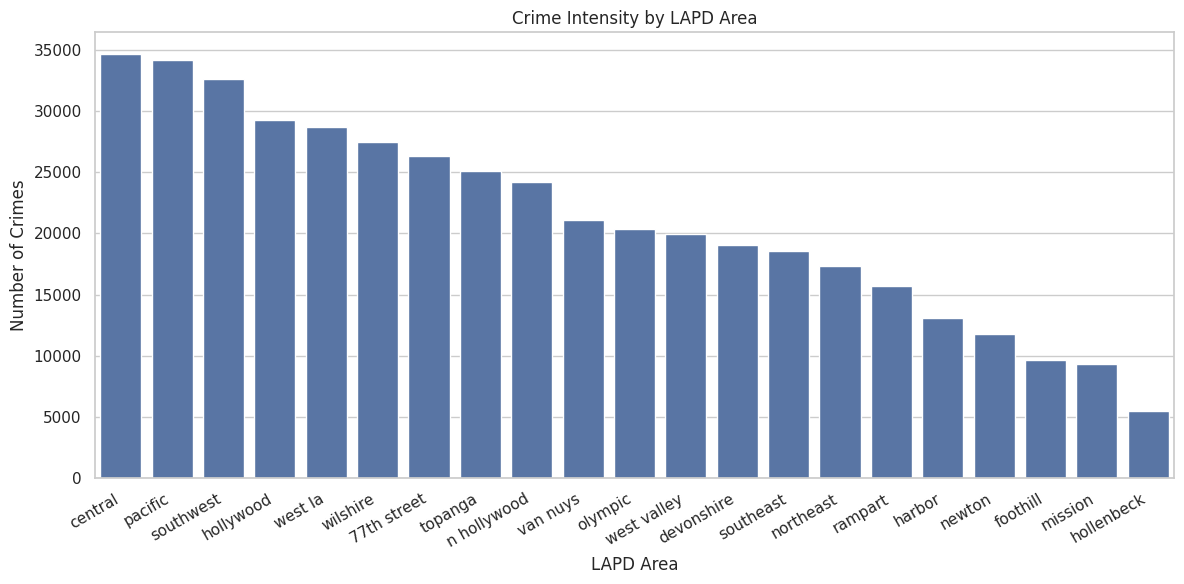

In [ ]:
# area_name × dr_no (count)
# Aggregate: crime count by area
area_crime_counts = (
    df.groupby('area_name')['dr_no']
      .count()
      .reset_index(name='crime_count')
      .sort_values('crime_count', ascending=False)
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=area_crime_counts,
    x='area_name',
    y='crime_count'
)

plt.title('Crime Intensity by LAPD Area')
plt.xlabel('LAPD Area')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

**At what times of day do crime hotspots peak?**

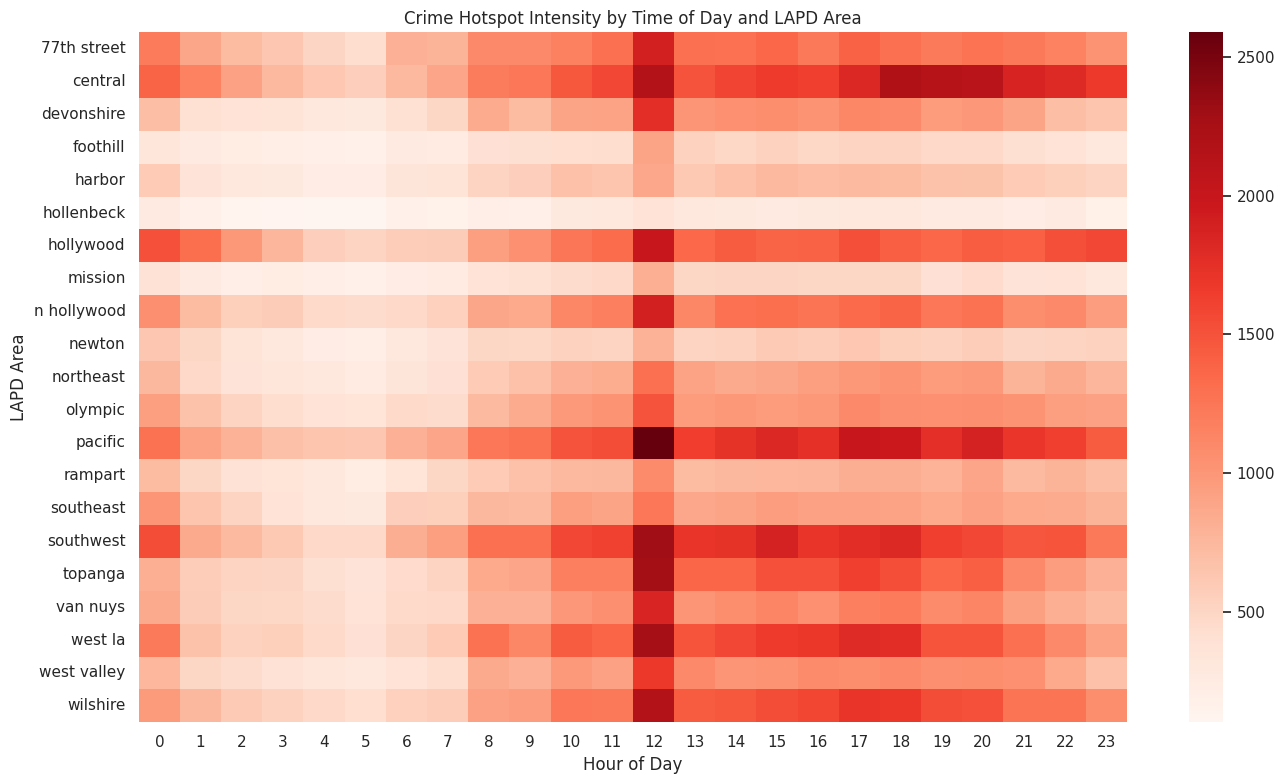

In [ ]:
# Create hour variable if not already created
df['time_occ_hour'] = df['time_occ_time_hour']

# Aggregate: crime counts by area and hour
heatmap_data = (
    df.groupby(['area_name', 'time_occ_hour'])
      .size()
      .reset_index(name='crime_count')
)

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(
    index='area_name',
    columns='time_occ_hour',
    values='crime_count'
).fillna(0)

plt.figure(figsize=(14, 8))

sns.heatmap(
    heatmap_pivot,
    cmap='Reds'
)

plt.title('Crime Hotspot Intensity by Time of Day and LAPD Area')
plt.xlabel('Hour of Day')
plt.ylabel('LAPD Area')

plt.tight_layout()
plt.show()

**Are crime hotspots consistent across months and years?**

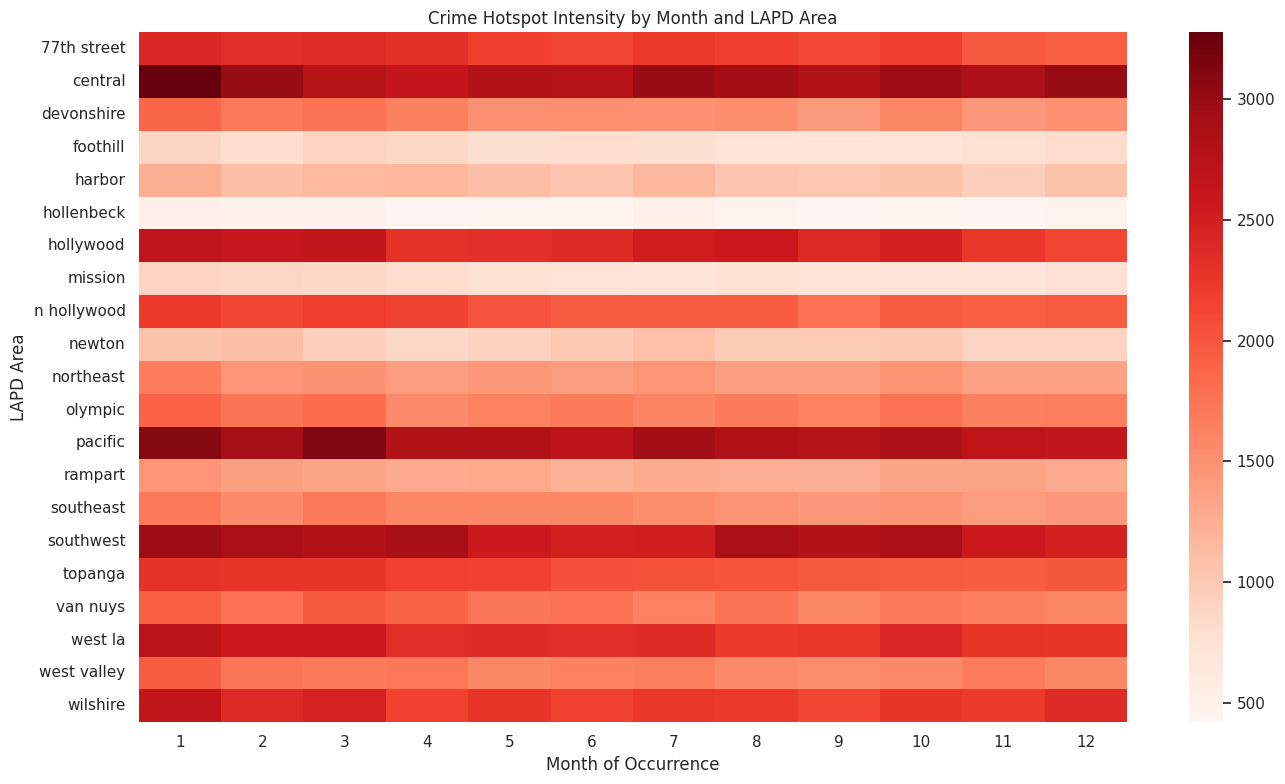

In [ ]:
# date_occ_month, date_occ_year × area_name
# Aggregate: crime counts by area and month
area_month = (
    df.groupby(['area_name', 'date_occ_month'])
      .size()
      .reset_index(name='crime_count')
)

# Pivot for heatmap
area_month_pivot = area_month.pivot(
    index='area_name',
    columns='date_occ_month',
    values='crime_count'
).fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    area_month_pivot,
    cmap='Reds'
)

plt.title('Crime Hotspot Intensity by Month and LAPD Area')
plt.xlabel('Month of Occurrence')
plt.ylabel('LAPD Area')

plt.tight_layout()
plt.show()

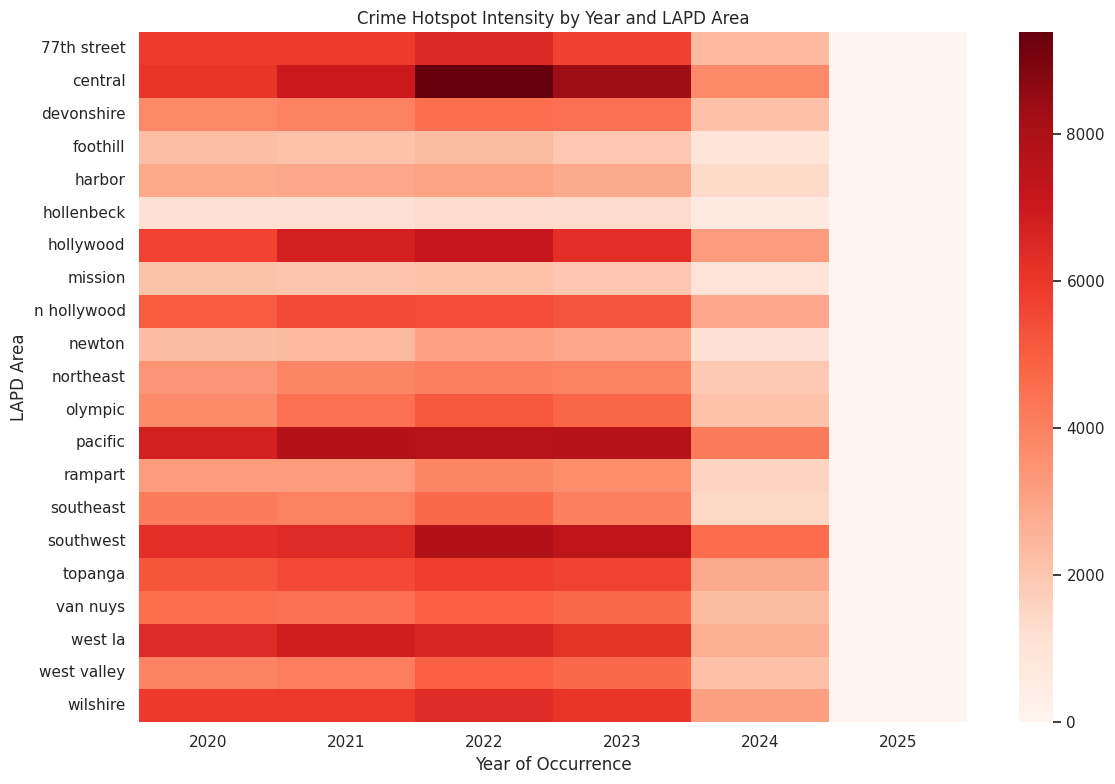

In [ ]:
# Aggregate: crime counts by area and year
area_year = (
    df.groupby(['area_name', 'date_occ_year'])
      .size()
      .reset_index(name='crime_count')
)

# Pivot for heatmap
area_year_pivot = area_year.pivot(
    index='area_name',
    columns='date_occ_year',
    values='crime_count'
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    area_year_pivot,
    cmap='Reds'
)

plt.title('Crime Hotspot Intensity by Year and LAPD Area')
plt.xlabel('Year of Occurrence')
plt.ylabel('LAPD Area')

plt.tight_layout()
plt.show()


**How does victim age vary by crime type?**

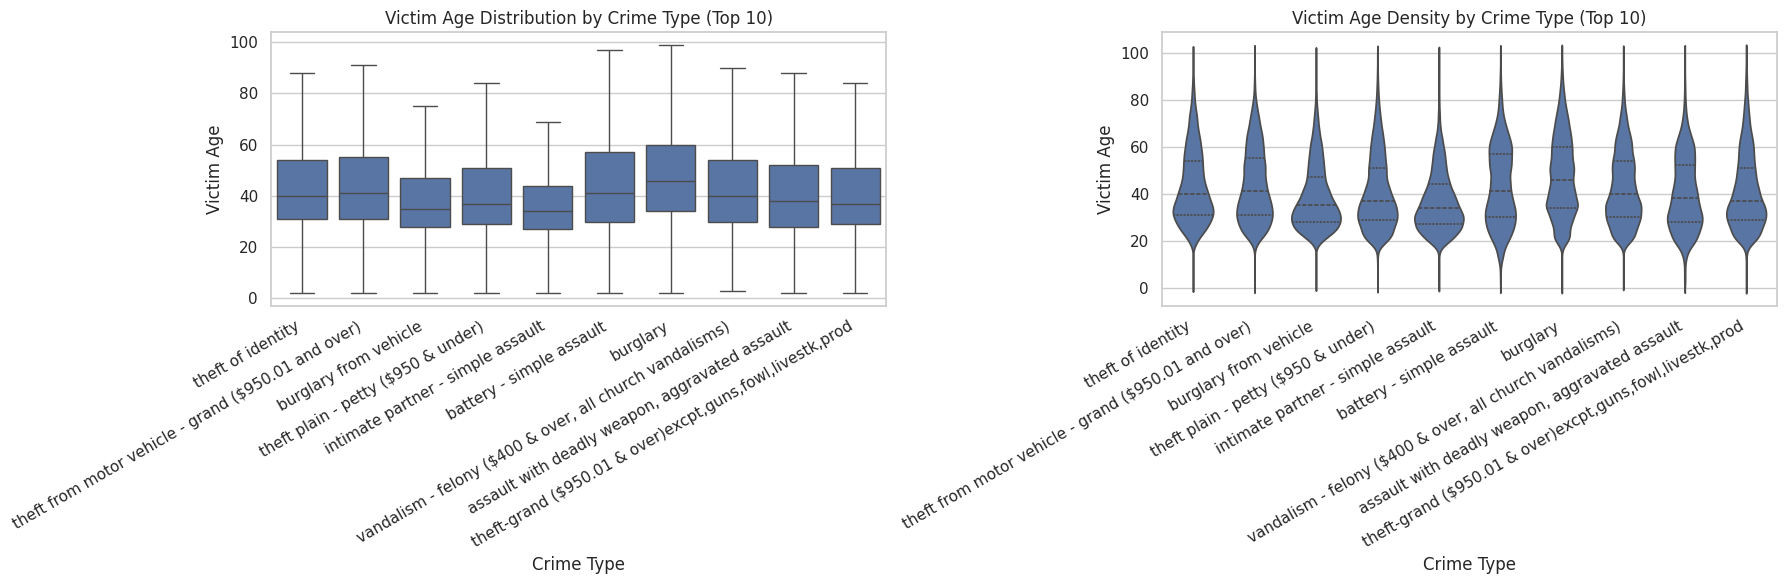

In [ ]:
# Select top 10 crime types
top_10_crimes = (
    df['crm_cd_desc']
    .value_counts()
    .head(10)
    .index
)

df_top10 = df[df['crm_cd_desc'].isin(top_10_crimes)]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Boxplot: victim age distribution
sns.boxplot(
    data=df_top10,
    x='crm_cd_desc',
    y='vict_age',
    showfliers=False,
    ax=ax[0]
)
ax[0].set_title('Victim Age Distribution by Crime Type (Top 10)')
ax[0].set_xlabel('Crime Type')
ax[0].set_ylabel('Victim Age')
ax[0].tick_params(axis='x', rotation=30)
for label in ax[0].get_xticklabels():
    label.set_ha('right')

# Violin plot: age density
sns.violinplot(
    data=df_top10,
    x='crm_cd_desc',
    y='vict_age',
    inner='quartile',
    ax=ax[1]
)
ax[1].set_title('Victim Age Density by Crime Type (Top 10)')
ax[1].set_xlabel('Crime Type')
ax[1].set_ylabel('Victim Age')
ax[1].tick_params(axis='x', rotation=30)
for label in ax[1].get_xticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()

**Do certain LAPD areas have younger or older victim populations?**

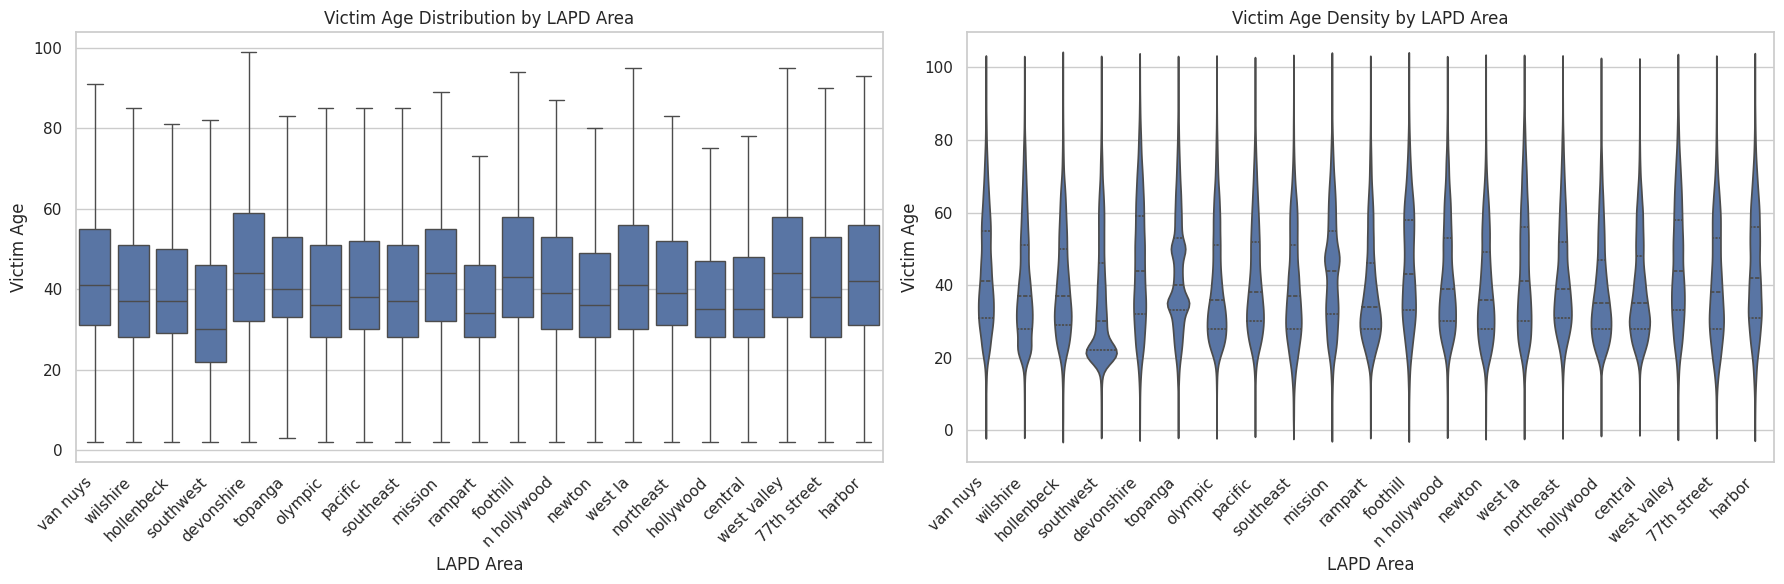

In [ ]:
# area_name × vict_age
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Boxplot: victim age distribution by area
sns.boxplot(
    data=df,
    x='area_name',
    y='vict_age',
    showfliers=False,
    ax=ax[0]
)
ax[0].set_title('Victim Age Distribution by LAPD Area')
ax[0].set_xlabel('LAPD Area')
ax[0].set_ylabel('Victim Age')
ax[0].tick_params(axis='x', rotation=45)
for label in ax[0].get_xticklabels():
    label.set_ha('right')

# Violin plot: age density by area
sns.violinplot(
    data=df,
    x='area_name',
    y='vict_age',
    inner='quartile',
    ax=ax[1]
)
ax[1].set_title('Victim Age Density by LAPD Area')
ax[1].set_xlabel('LAPD Area')
ax[1].set_ylabel('Victim Age')
ax[1].tick_params(axis='x', rotation=45)
for label in ax[1].get_xticklabels():
    label.set_ha('right')

plt.tight_layout()
plt.show()

## Multivariate Analysis

**Do high-crime areas also experience longer reporting delays?**


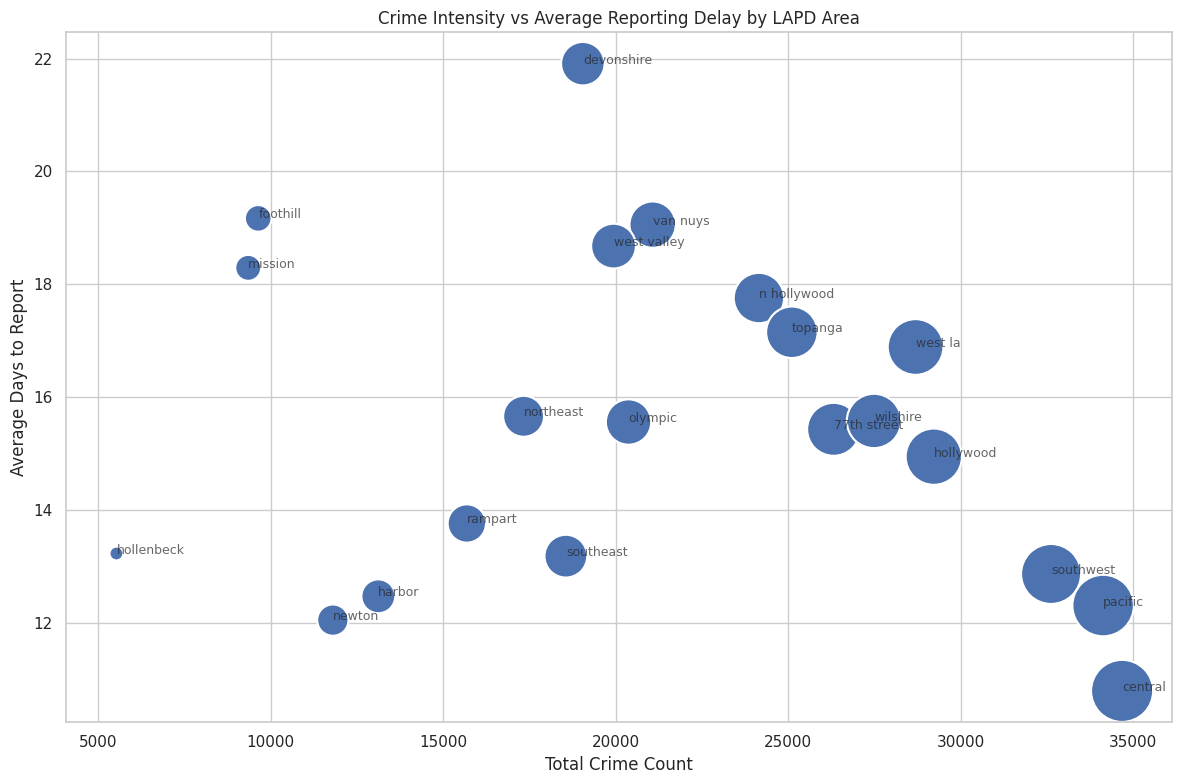

In [ ]:
# area_name × days_to_report × crime count
area_summary = (
    df.groupby('area_name')
      .agg(
          crime_count=('dr_no', 'count'),
          avg_days_to_report=('days_to_report', 'mean')
      )
      .reset_index()
)

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=area_summary,
    x='crime_count',
    y='avg_days_to_report',
    size='crime_count',
    sizes=(100, 2000),
    legend=False
)

plt.title('Crime Intensity vs Average Reporting Delay by LAPD Area')
plt.xlabel('Total Crime Count')
plt.ylabel('Average Days to Report')

# Annotate points with area names
for _, row in area_summary.iterrows():
    plt.text(
        row['crime_count'],
        row['avg_days_to_report'],
        row['area_name'],
        fontsize=9,
        alpha=0.7
    )

plt.tight_layout()
plt.show()

**Are crimes involving weapons both reported faster and concentrated in specific areas?**

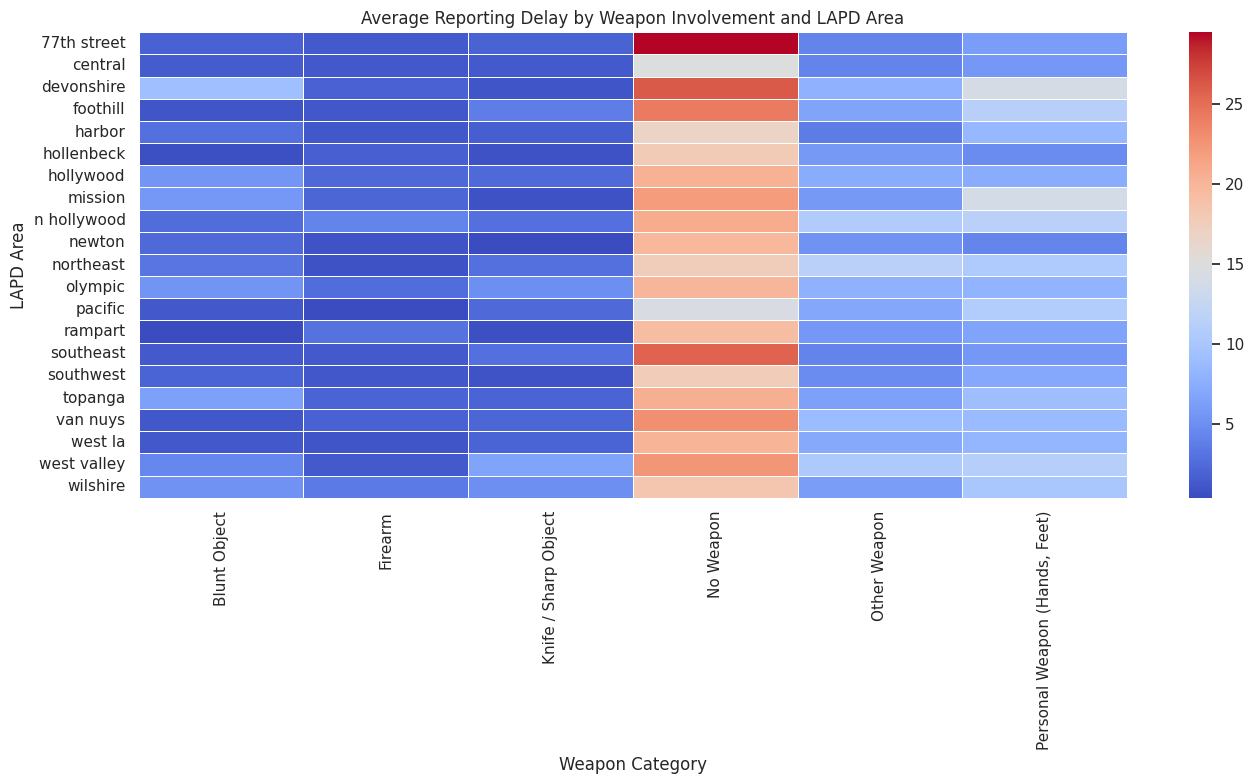

In [ ]:
# weapon_used_cd × area_name × days_to_report
weapon_area_delay = (
    df.groupby(['area_name', 'weapon_category'])
      .agg(avg_days_to_report=('days_to_report', 'mean'),
           crime_count=('dr_no', 'count'))
      .reset_index()
)
heatmap_data = weapon_area_delay.pivot(
    index='area_name',
    columns='weapon_category',
    values='avg_days_to_report'
)

plt.figure(figsize=(14, 8))

sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    linewidths=0.5
)

plt.title('Average Reporting Delay by Weapon Involvement and LAPD Area')
plt.xlabel('Weapon Category')
plt.ylabel('LAPD Area')

plt.tight_layout()
plt.show()

**How do crime type, victim demographics, and location jointly influence reporting delay?**

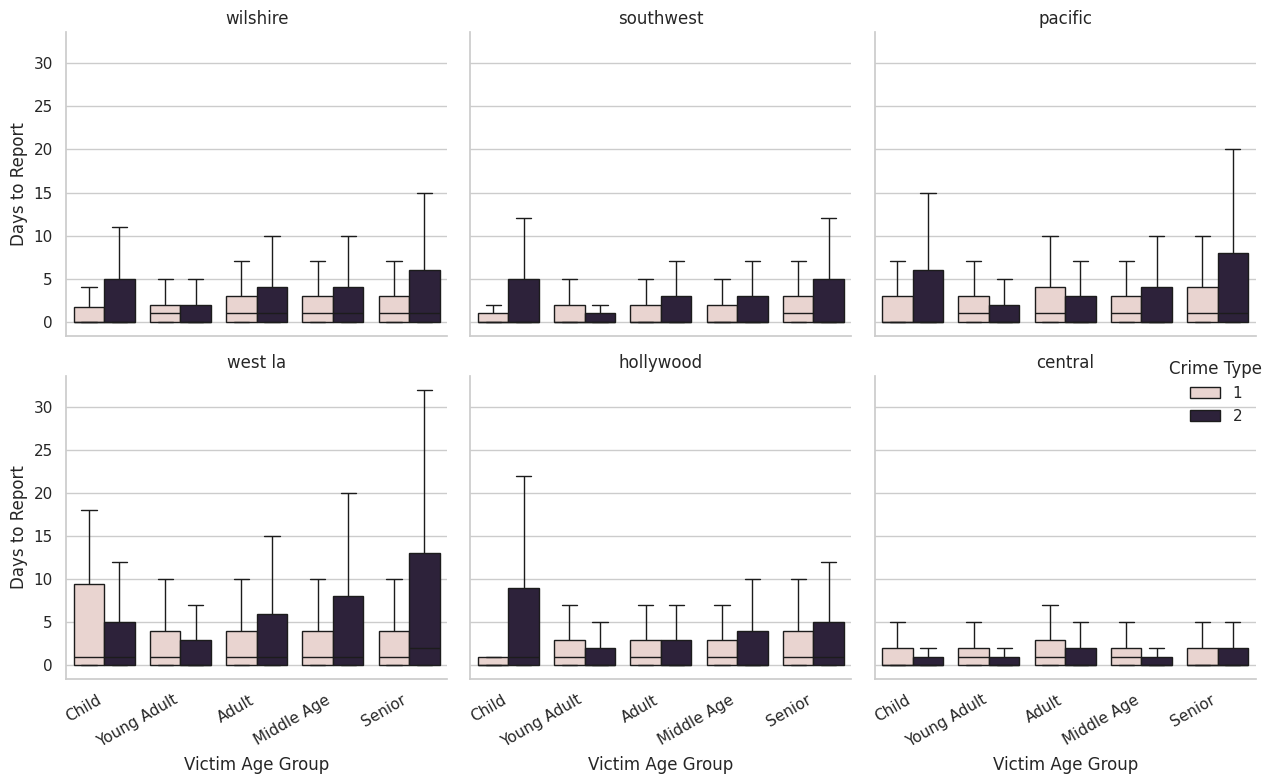

In [ ]:
# part_1-2, vict_age, vict_sex, vict_descent_grouped, area_name, days_to_report
# Create age groups
df['vict_age_group'] = pd.cut(
    df['vict_age'],
    bins=[0, 17, 29, 44, 64, 120],
    labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior']
)
top_6_areas = (
    df['area_name']
    .value_counts()
    .head(6)
    .index
)

df_plot = df[df['area_name'].isin(top_6_areas)]
g = sns.catplot(
    data=df_plot,
    x='vict_age_group',
    y='days_to_report',
    hue='part_1-2',
    col='area_name',
    kind='box',
    showfliers=False,
    col_wrap=3,
    height=4,
    aspect=1
)

g.set_titles('{col_name}')
g.set_axis_labels('Victim Age Group', 'Days to Report')
g._legend.set_title('Crime Type')

for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
    for label in ax.get_xticklabels():
        label.set_ha('right')

plt.tight_layout()
plt.show()

**Create dummy variables and save data to csv**

In [ ]:
# generate dummy variables for each categorical column (encode categorical variable)
categorical_cols = ['area_name', 'vict_descent_grouped', 'vict_sex', 'weapon_category', 'crime_type', 'premis_desc']
all_other_cols = ['time_occ_time_hour', 'dr_no', 'date_occ_day', 'date_rptd_day', 'crm_cd', 'crm_cd_1', 'rpt_duration']
encoded_df = pd.get_dummies(df[categorical_cols], drop_first=True, dtype=int)
# combine the encoded df with the numeric cols
df_encoded = pd.concat([df[all_other_cols], encoded_df], axis=1)

# split data 60/20/20 train, validate, test
train_validate, test = train_test_split(df_encoded, test_size=0.2, random_state=123, stratify=df_encoded['rpt_duration'])
train, validate = train_test_split(train_validate, test_size=0.25, random_state=123, stratify=train_validate['rpt_duration'])
train.shape, validate.shape, test.shape

((266281, 338), (88761, 338), (88761, 338))

**Save csv to current working director**

In [ ]:
dir = '/content/drive/MyDrive/DAT 490 - Forest Flux/data/' # change this to your directory
df.to_csv(dir + "crime_data_cleaned.csv", index=False)
train.to_csv(dir + "crime_data_train.csv", index=False)
validate.to_csv(dir + "crime_data_validate.csv", index=False)
test.to_csv(dir + "crime_data_test.csv", index=False)